In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from IPython.display import display, Image

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
train_data_path = "2019-2nd-ml-month-with-kakr/train.csv"
sub_data_path = "2019-2nd-ml-month-with-kakr/test.csv"

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
data.max()

id                         15034
date             20150514T000000
price                  7700000.0
bedrooms                      10
bathrooms                    8.0
sqft_living                13540
sqft_lot                 1651359
floors                       3.5
waterfront                     1
view                           4
condition                      5
grade                         13
sqft_above                  9410
sqft_basement               4130
yr_built                    2015
yr_renovated                2015
zipcode                    98199
lat                      47.7776
long                    -121.315
sqft_living15               6210
sqft_lot15                871200
dtype: object

In [117]:
data.min()

id                             0
date             20140502T000000
price                    78000.0
bedrooms                       0
bathrooms                    0.0
sqft_living                  290
sqft_lot                     520
floors                       1.0
waterfront                     0
view                           0
condition                      1
grade                          1
sqft_above                   290
sqft_basement                  0
yr_built                    1900
yr_renovated                   0
zipcode                    98001
lat                      47.1559
long                    -122.519
sqft_living15                399
sqft_lot15                   651
dtype: object

In [115]:
data[data['waterfront'] != 0].min()

id                           160
date             20140509T000000
price                   285000.0
bedrooms                       1
bathrooms                   0.75
sqft_living                  720
sqft_lot                    1767
floors                       1.0
waterfront                     1
view                           1
condition                      1
grade                          5
sqft_above                   560
sqft_basement                  0
yr_built                    1903
yr_renovated                   0
zipcode                    98004
lat                      47.3351
long                    -122.514
sqft_living15                750
sqft_lot15                  3230
dtype: object

In [116]:
data[data['waterfront'] != 0].max()

id                         14724
date             20150511T000000
price                  7062500.0
bedrooms                       6
bathrooms                    6.0
sqft_living                10040
sqft_lot                  505166
floors                       3.0
waterfront                     1
view                           4
condition                      5
grade                         12
sqft_above                  7680
sqft_basement               2390
yr_built                    2014
yr_renovated                2006
zipcode                    98199
lat                      47.7729
long                    -122.059
sqft_living15               4620
sqft_lot15                127195
dtype: object

In [7]:
set(data['zipcode'])

{98001,
 98002,
 98003,
 98004,
 98005,
 98006,
 98007,
 98008,
 98010,
 98011,
 98014,
 98019,
 98022,
 98023,
 98024,
 98027,
 98028,
 98029,
 98030,
 98031,
 98032,
 98033,
 98034,
 98038,
 98039,
 98040,
 98042,
 98045,
 98052,
 98053,
 98055,
 98056,
 98058,
 98059,
 98065,
 98070,
 98072,
 98074,
 98075,
 98077,
 98092,
 98102,
 98103,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98119,
 98122,
 98125,
 98126,
 98133,
 98136,
 98144,
 98146,
 98148,
 98155,
 98166,
 98168,
 98177,
 98178,
 98188,
 98198,
 98199}

In [8]:
len(set(data['zipcode']))

70

In [54]:
sub['zipcode'].max()

98199

In [4]:
y = data['price']
del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

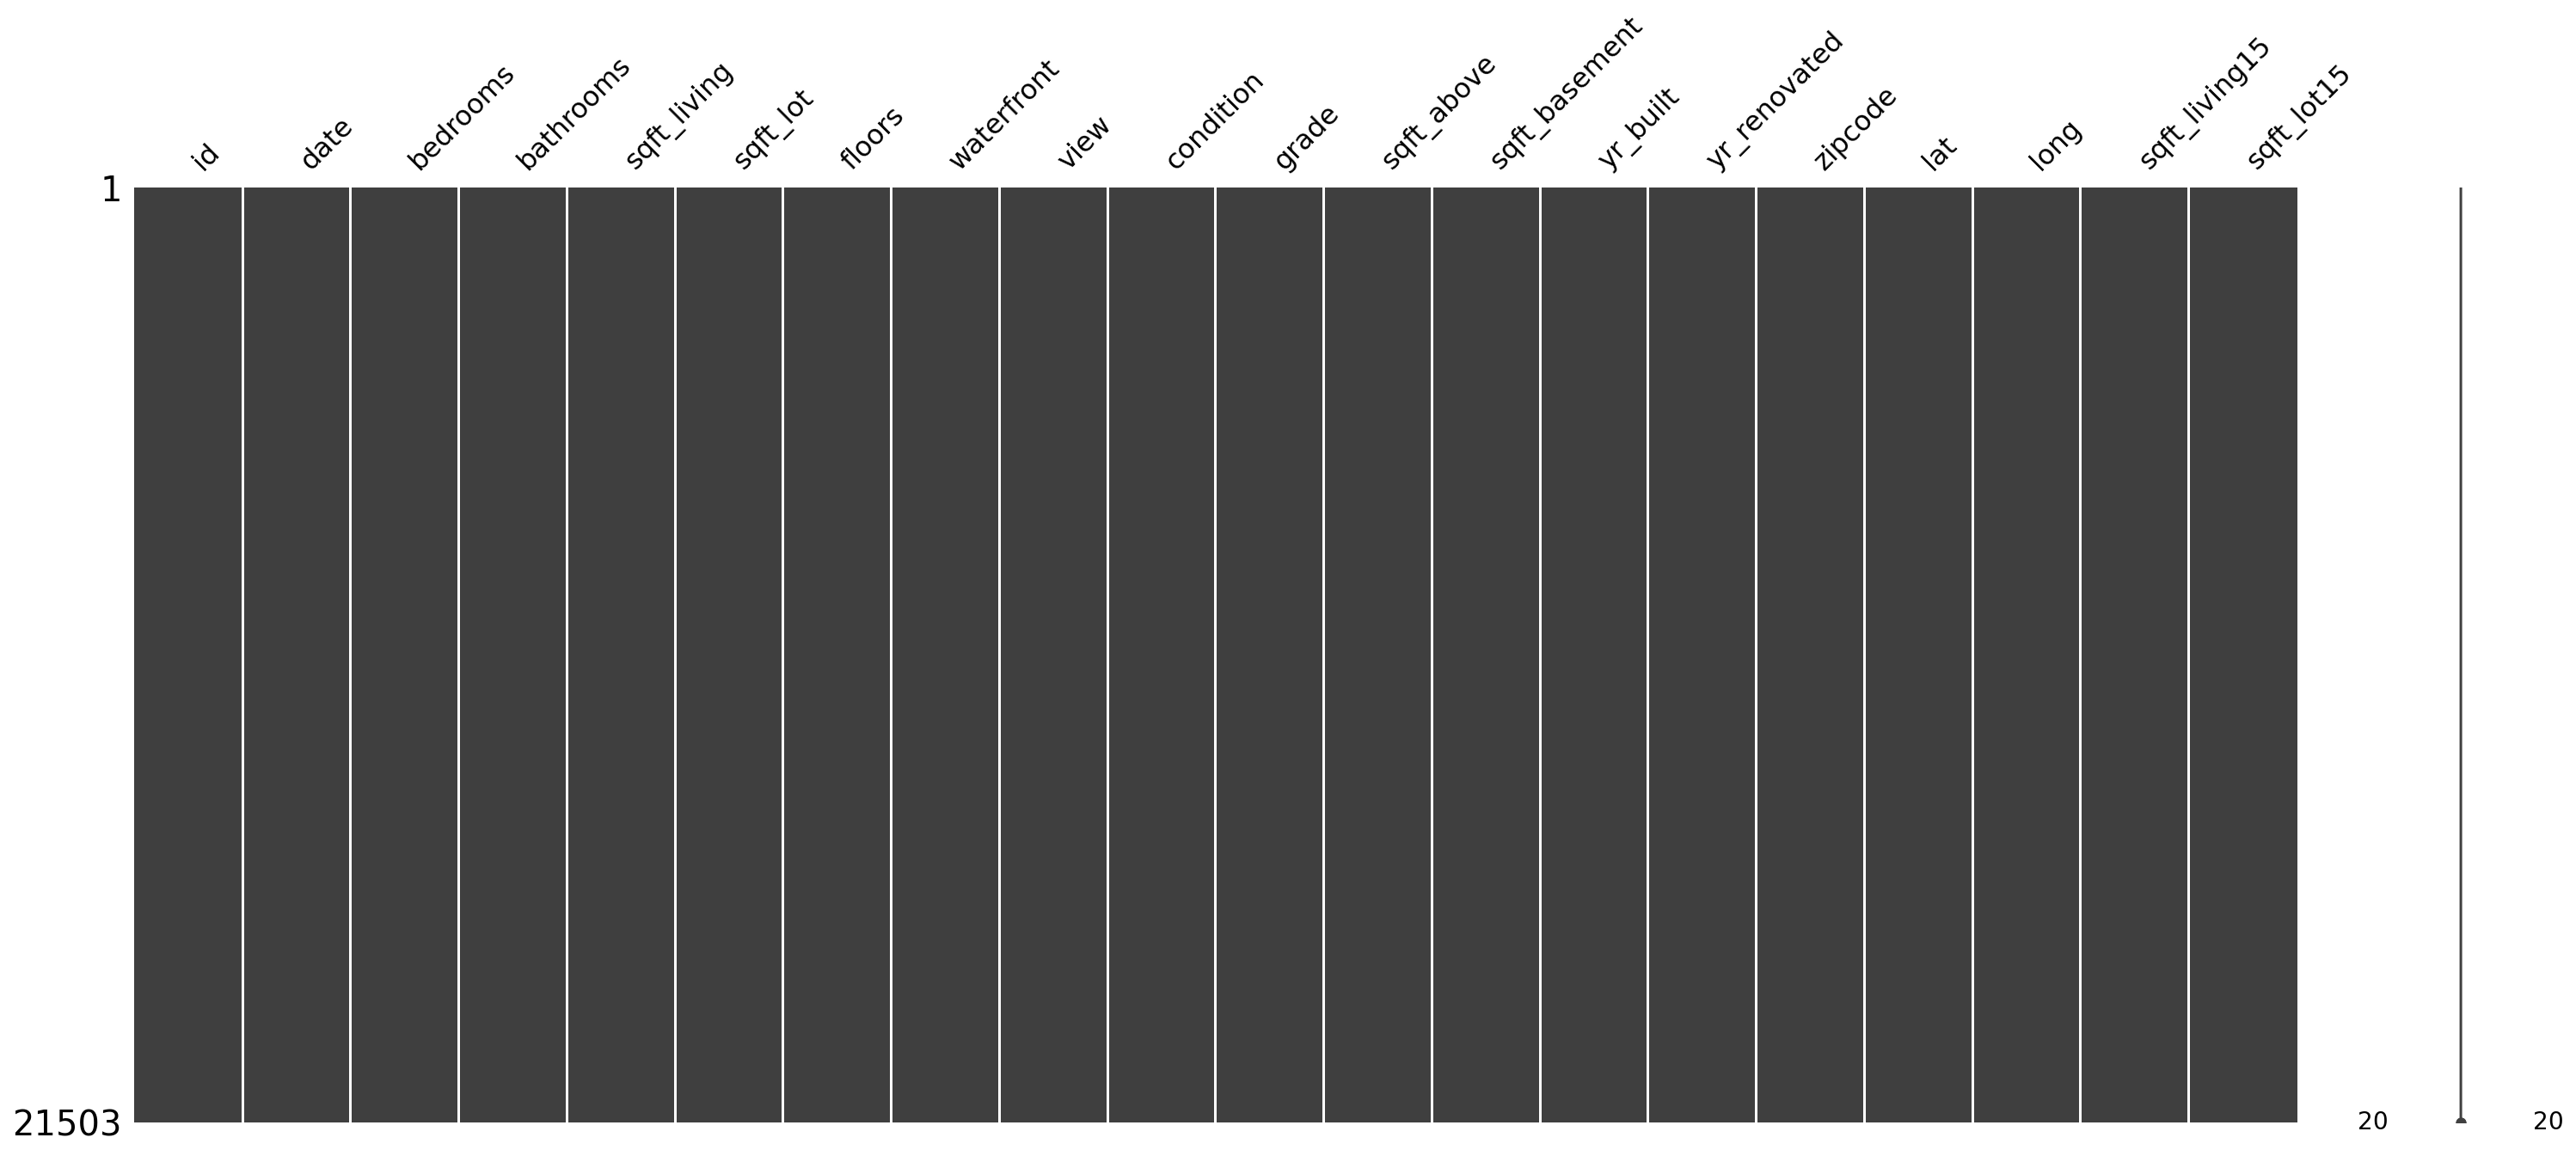

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [134]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

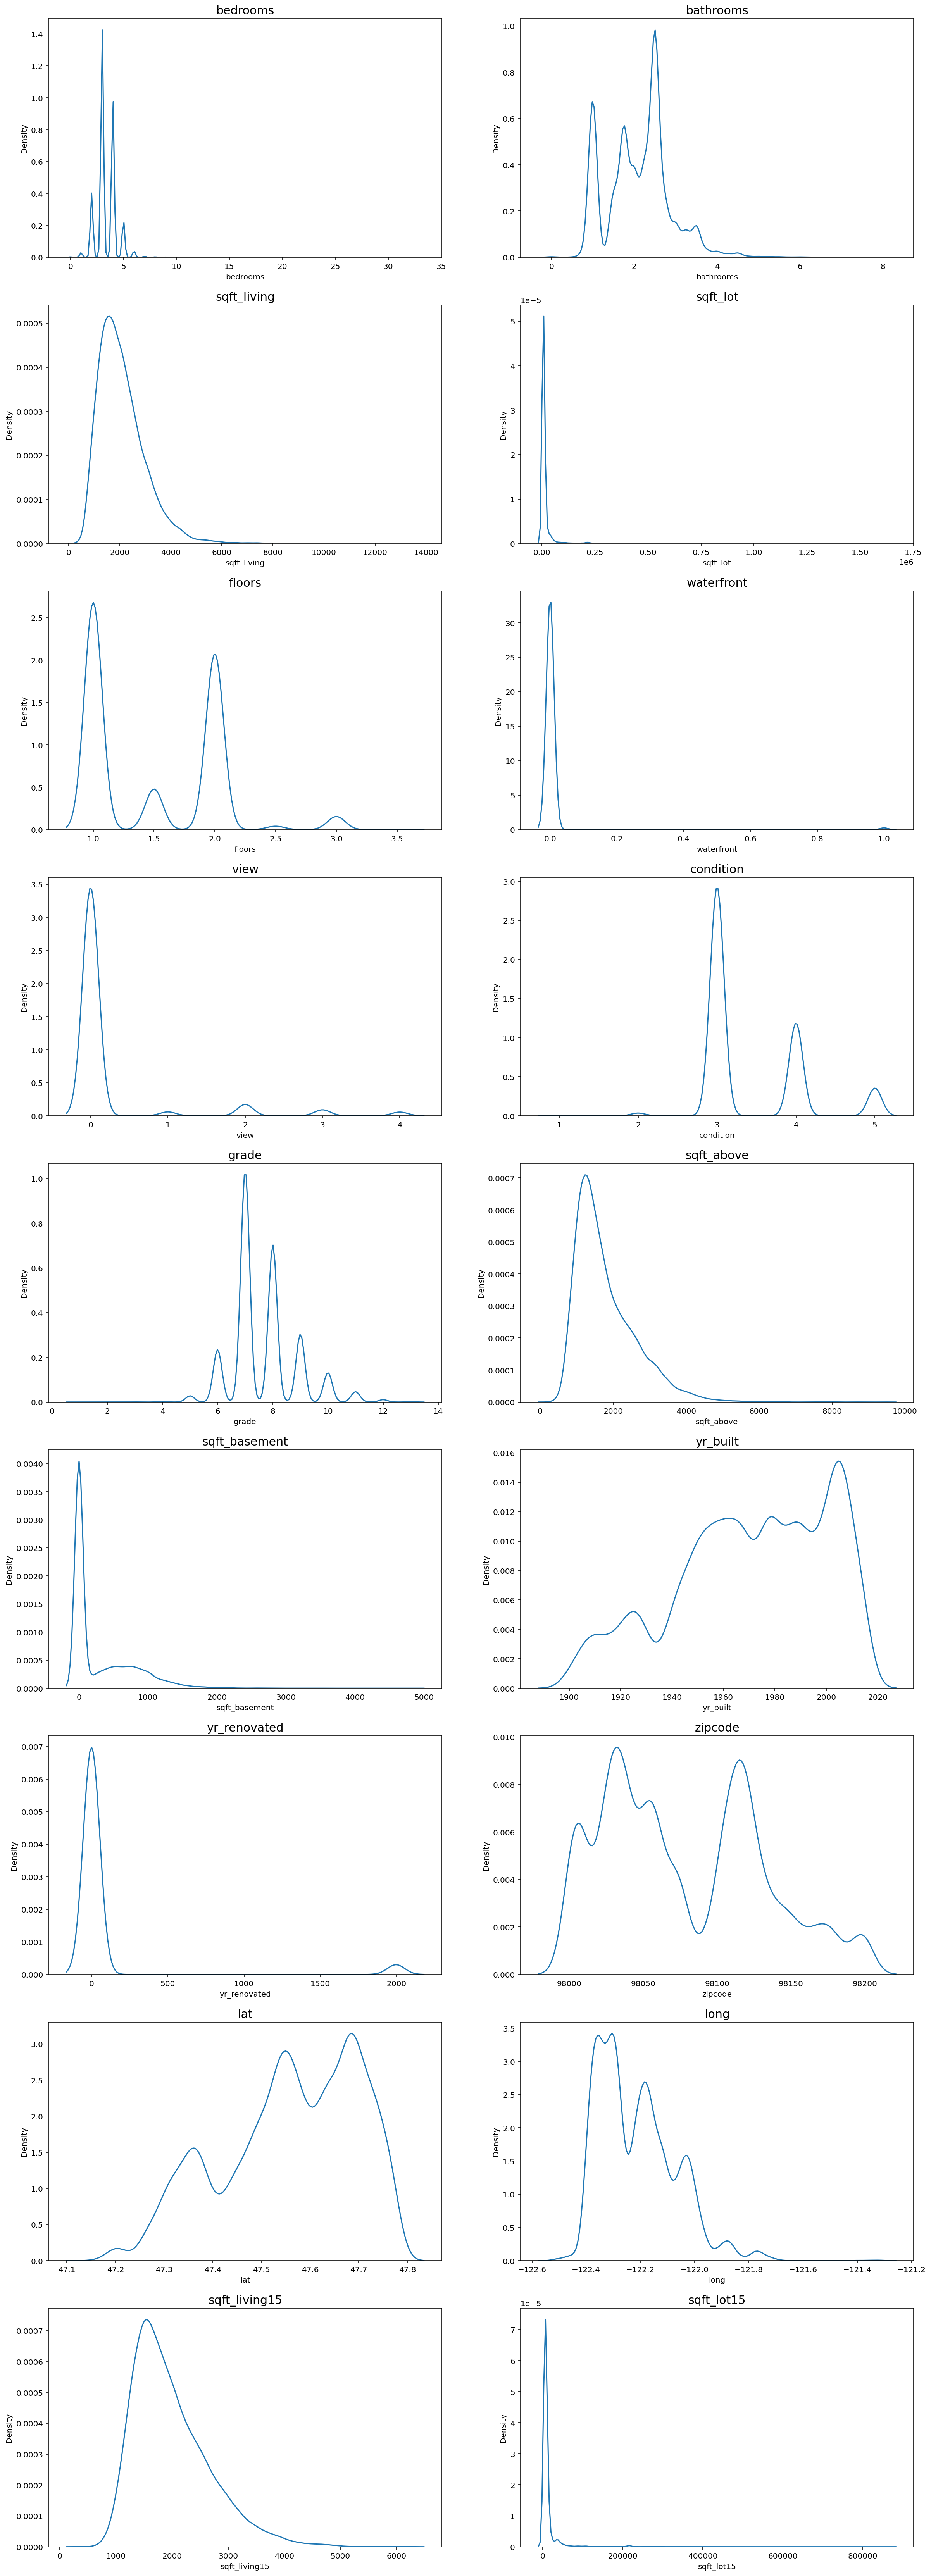

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

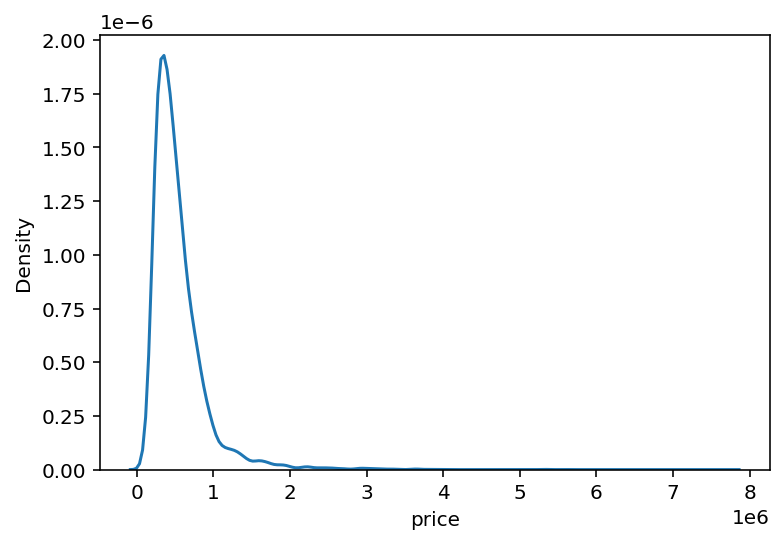

In [11]:
sns.kdeplot(y)
plt.show()

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

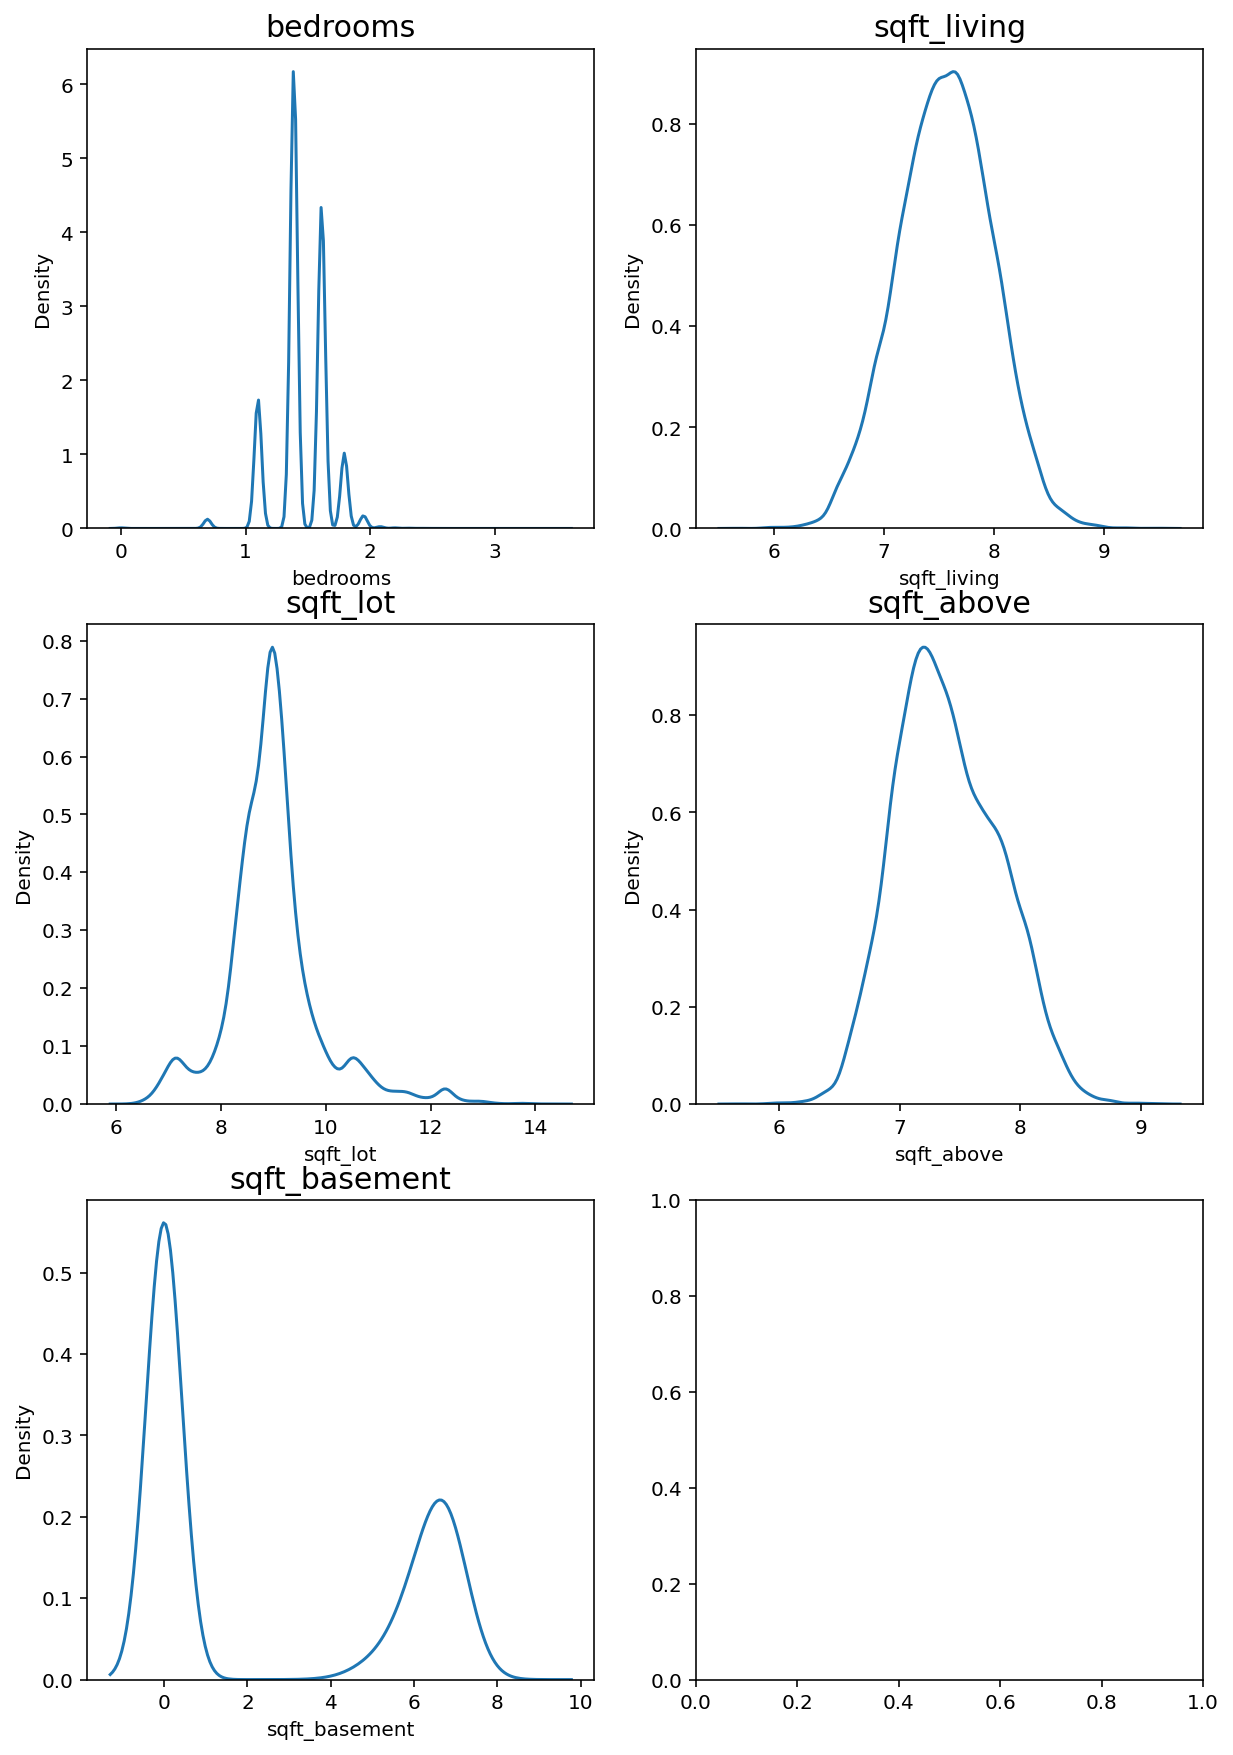

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [14]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007


In [139]:
test_data = data.copy()

# 1. 15X

In [26]:
test_data = test_data.drop(columns=['sqft_living15', 'sqft_lot15'])

In [27]:
test_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299


In [28]:
sub = test_data.iloc[train_len:, :]
x = test_data.iloc[:train_len, :]

# 2. 15만

In [37]:
test_data = test_data.drop(columns=['sqft_living', 'sqft_lot'])

In [38]:
test_data

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,1.386294,2.00,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,1.386294,2.50,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,1.098612,0.75,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007


# 3. 둘다

In [47]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

### 중간 점검 결과: 토지 데이터중 15년 기준 데이터와 아닌 데이터 비교 결과 15년 기준이 점수가 더 낮았다.

### 그래서 15년 기준 데이터를 쓰기로 결정했습니다.

# 가격, 15년기준 주거공간, 부지의 이상치를 구해보기로 했습니다.

In [143]:
test_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [144]:
Q3, Q1 = np.percentile(y, [75 ,25])
IQR = Q3 - Q1
IQR

323000.0

In [145]:
y[(Q1- 1.5 *IQR > y) | (Q3+ 1.5 * IQR < y)]

16       2000000.0
98       2250000.0
149      1505000.0
174      2400000.0
191      2900000.0
           ...    
14990    1375000.0
15004    1700000.0
15021    1222500.0
15025    1575000.0
15027    1537000.0
Name: price, Length: 797, dtype: float64

In [146]:
y_point = y[(Q1- 1.5 *IQR > y) | (Q3+ 1.5 * IQR < y)].index

In [147]:
y_point

Int64Index([   16,    98,   149,   174,   191,   192,   199,   212,   221,
              222,
            ...
            14953, 14969, 14973, 14975, 14981, 14990, 15004, 15021, 15025,
            15027],
           dtype='int64', length=797)

In [148]:
y_point.shape

(797,)

In [149]:
y = y.drop(y_point)

In [150]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 14238, dtype: float64

In [152]:
test_data = test_data.drop(y_point)

In [153]:
test_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [154]:
train_len = len(test_data)
test_data = pd.concat((test_data, sub), axis=0)

In [155]:
sub_id = test_data['id'][train_len:]
del test_data['id']
test_data['date'] = test_data['date'].apply(lambda x : str(x[:6])).astype(str)

In [159]:
del test_data['price']

In [160]:
test_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


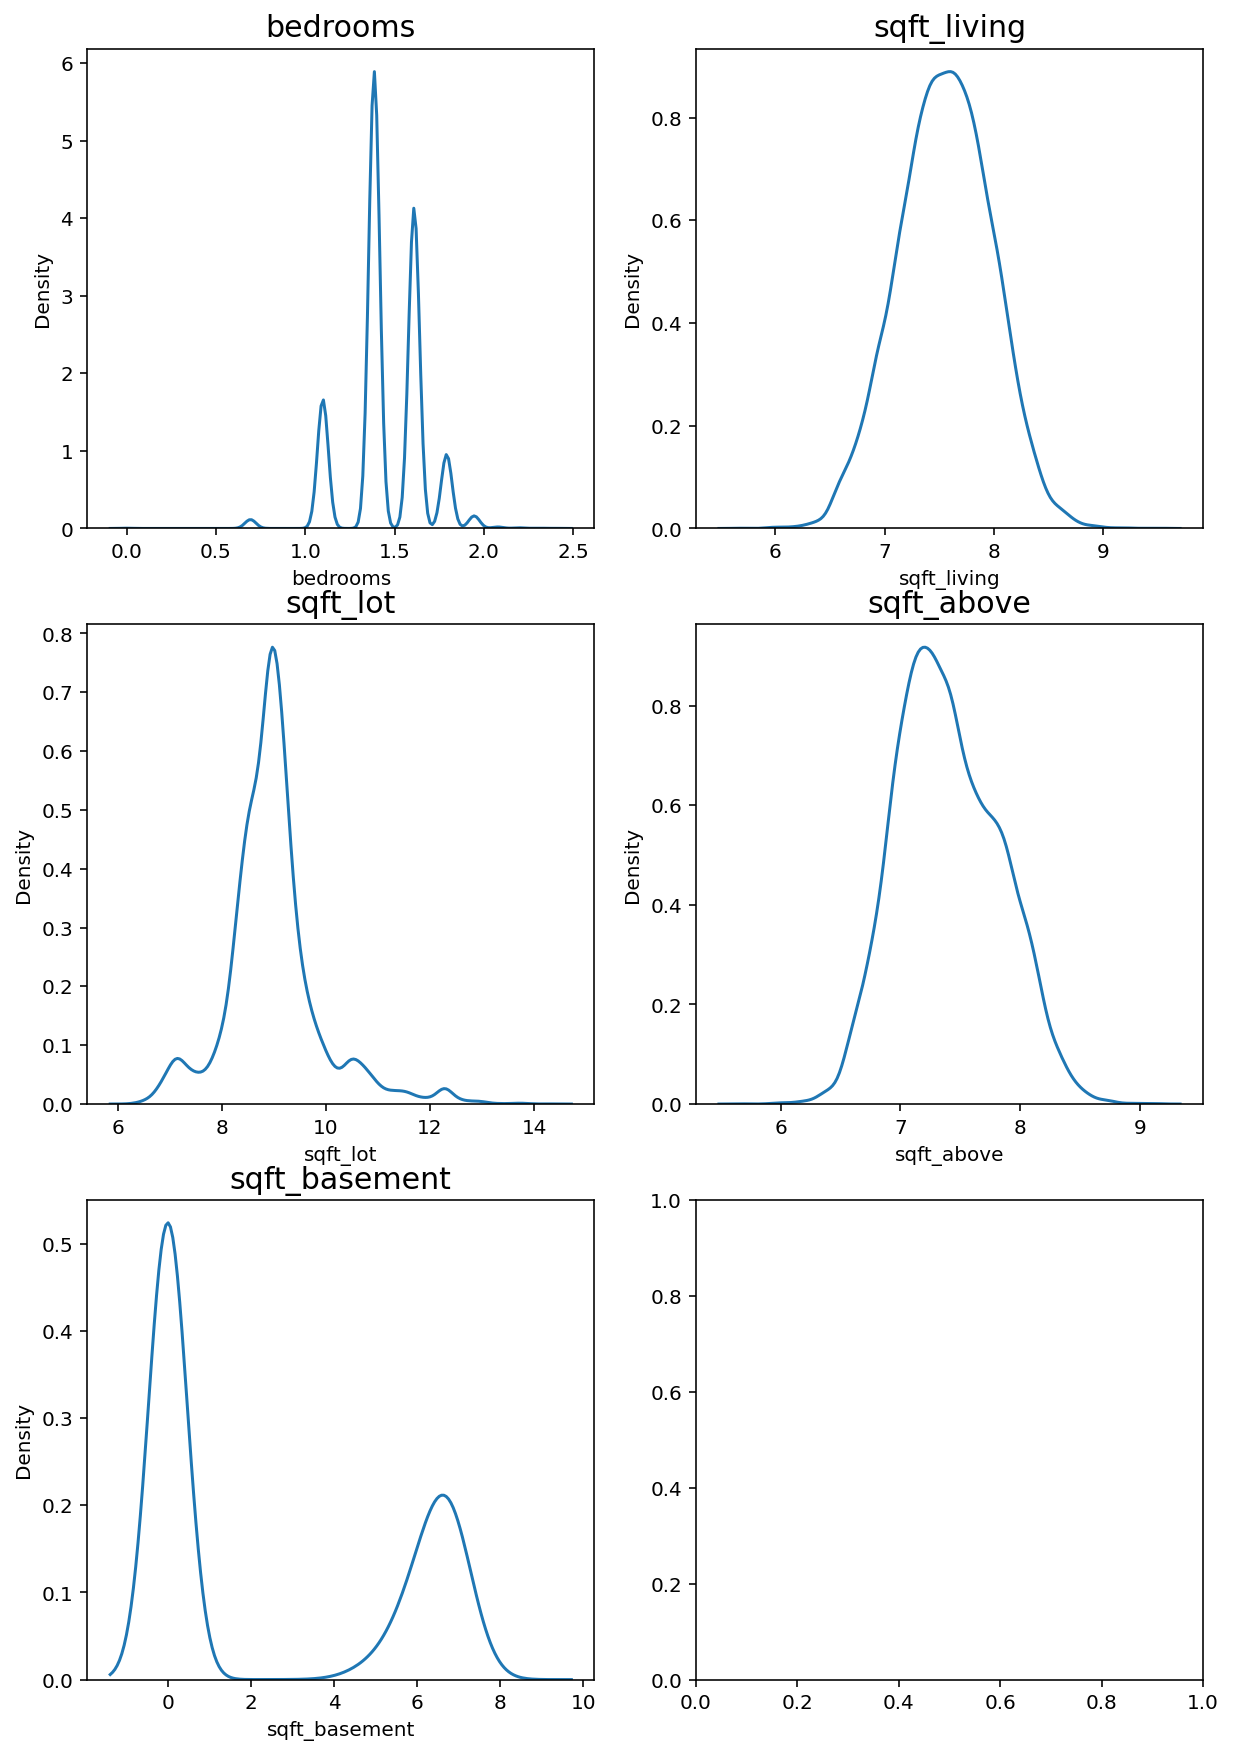

In [161]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    test_data[c] = np.log1p(test_data[c].values)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [162]:
sub = test_data.iloc[train_len:, :]
x = test_data.iloc[:train_len, :]

In [163]:
x.shape

(14238, 19)

In [164]:
sub.shape

(6468, 19)

# 이상치 제거후 점수를 봤는데 점수가 이만점이 넘었다...

# 그래서 다시 가설을 정한후 데이터 전처리를 다시 하기로 했다.

#  모델 3개로만 했을 때

## 3-1. 모델링 
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [165]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [166]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [167]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8413
Model XGBoost CV score : 0.8668
Model LightGBM CV score : 0.8759


### 예측 값 출력 및 저장

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [168]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [169]:
y_pred = AveragingBlending(models, x, y, sub)

In [170]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub

,id,price
0,15035,5.415779e+05
1,15036,4.558946e+05
2,15037,1.025088e+06
3,15038,3.097957e+05
4,15039,3.189727e+05
...,...,...
6463,21498,2.361150e+05
6464,21499,4.022809e+05
6465,21500,4.659892e+05
6466,21501,3.223814e+05


In [171]:
sub.to_csv('submission.csv', index=False)

# 모델 4개로 했을 때

# 3-2 모델링, rmse 계산

In [5]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


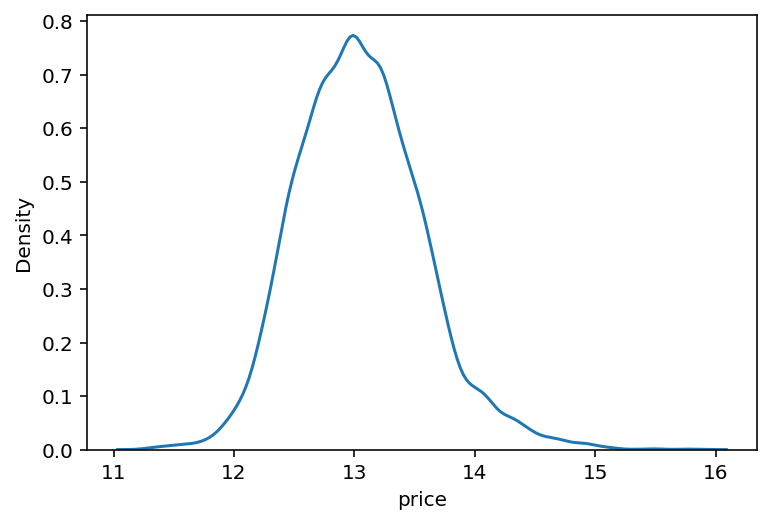

In [10]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [37]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


# 데이터 전처리

In [164]:
train_ple = train.copy()
test_ple = test.copy()
y_ple = y.copy()

In [141]:
train_ple

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [50]:
train_ple = train_ple[train['yr_renovated'] == 0]
train_ple

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [51]:
train_ple = train_ple.drop(['yr_renovated'], axis = 1)
test_ple = test_ple.drop(['yr_renovated'], axis = 1)
y_ple = y_ple[train['yr_renovated'] == 0]

In [354]:
train_ple1 = train.copy()
test_ple1 = test.copy()
y_ple1 = y.copy()

In [355]:
train_ple1 = train_ple1[(train['yr_renovated'] == 0) & (train['waterfront'] == 0)]
y_ple1 = y_ple1[(train['yr_renovated'] == 0) & (train['waterfront'] == 0)]

In [356]:
train_ple1 = train_ple1.drop(['yr_renovated', 'waterfront'], axis = 1)
test_ple1 = test_ple1.drop(['yr_renovated', 'waterfront'], axis = 1)

In [167]:
train_ple1

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [168]:
test_ple1

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [315]:
train_ple3 = train.copy()
test_ple3 = test.copy()
y_ple3 = y.copy()

In [316]:
train_ple3 = train_ple3[train['waterfront'] == 0]
y_ple3 = y_ple3[train['waterfront'] == 0]

In [317]:
train_ple3 = train_ple3.drop(['waterfront'], axis = 1)
test_ple3 = test_ple3.drop(['waterfront'], axis = 1)

In [333]:
y_ple3

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 14928, dtype: float64

In [350]:
train_ple4 = train.copy()
test_ple4 = test.copy()
y_ple4 = y.copy()

In [351]:
train_ple4 = train_ple4[(train['yr_renovated'] == 0) | (train['waterfront'] == 0)]
y_ple4 = y_ple4[(train['waterfront'] == 0) | (train['yr_renovated'] == 0)]

In [352]:
train_ple4 = train_ple4.drop(['yr_renovated', 'waterfront'], axis = 1)
test_ple4 = test_ple4.drop(['yr_renovated', 'waterfront'], axis = 1)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier

In [14]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
linear =  LinearRegression()
decision_tree = DecisionTreeClassifier(random_state=random_state)
svm_model = svm.SVC()
sgd_model = SGDClassifier()

models = [gboost, xgboost, lightgbm, rdforest, linear]

In [15]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.22)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [16]:
get_scores(models, train, y)

,RMSE
LinearRegression,181304.125482
GradientBoostingRegressor,127794.435994
RandomForestRegressor,126787.065455
XGBRegressor,111191.257032
LGBMRegressor,109986.684382


In [52]:
get_scores(models, train_ple, y_ple)

,RMSE
LinearRegression,288119.852525
GradientBoostingRegressor,131621.457028
RandomForestRegressor,131604.310255
XGBRegressor,111792.612532
LGBMRegressor,111276.513816


In [357]:
get_scores(models, train_ple1, y_ple1)

,RMSE
LinearRegression,272334.269201
GradientBoostingRegressor,128853.302895
RandomForestRegressor,114836.266208
LGBMRegressor,113793.402040
XGBRegressor,108698.739744


In [318]:
get_scores(models, train_ple3, y_ple3)

,RMSE
LinearRegression,195550.430041
GradientBoostingRegressor,132060.186808
RandomForestRegressor,122402.740093
LGBMRegressor,117530.447323
XGBRegressor,111811.405659


In [353]:
get_scores(models, train_ple4, y_ple4)

,RMSE
LinearRegression,196692.964232
GradientBoostingRegressor,151411.222023
RandomForestRegressor,139592.279481
XGBRegressor,128743.321113
LGBMRegressor,126206.520949


In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    print(results)

In [99]:
param_grid = {
    'n_estimators': [10, 200],
    'max_depth': [1, 5],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3          5           200 -0.027160  0.164803
1          1           200 -0.045195  0.212591
2          5            10 -0.080875  0.284385
0          1            10 -0.163086  0.403839


In [101]:
param_grid = {
    'n_estimators': [10, 300],
    'max_depth': [1, 5],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3          5           300 -0.026606  0.163112
1          1           300 -0.042028  0.205008
2          5            10 -0.080875  0.284385
0          1            10 -0.163086  0.403839


In [128]:
param_grid = {
    'n_estimators': [10, 300],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           300 -0.026127  0.161640
1          5           300 -0.026606  0.163112
2         10            10 -0.078234  0.279704
0          5            10 -0.080875  0.284385


In [129]:
param_grid = {
    'n_estimators': [10, 340],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           340 -0.026108  0.161578
1          5           340 -0.026547  0.162933
2         10            10 -0.078234  0.279704
0          5            10 -0.080875  0.284385


In [19]:
param_grid = {
    'n_estimators': [10, 345],
    'max_depth': [5, 10],
    'learning_rate' : [ 0.06,0.07,0.08]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
    learning_rate  max_depth  n_estimators     score     RMSLE
11           0.08         10           345 -0.026069  0.161458
7            0.07         10           345 -0.026134  0.161659
3            0.06         10           345 -0.026156  0.161728
9            0.08          5           345 -0.026647  0.163240
5            0.07          5           345 -0.026844  0.163841
1            0.06          5           345 -0.026847  0.163851
10           0.08         10            10 -0.095833  0.309570
8            0.08          5            10 -0.098401  0.313689
6            0.07         10            10 -0.107285  0.327544
4            0.07          5            10 -0.109643  0.331124
2            0.06         10            10 -0.120975  0.347814
0            0.06          5            10 -0.122998 

In [21]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [5, 10],
    'learning_rate' : [ 0.08,0.09,0.1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
3            0.08         10           366 -0.026065  0.161446
2            0.08         10           345 -0.026069  0.161458
11           0.10         10           366 -0.026088  0.161518
10           0.10         10           345 -0.026104  0.161567
6            0.09         10           345 -0.026219  0.161922
7            0.09         10           366 -0.026224  0.161940
9            0.10          5           366 -0.026514  0.162830
5            0.09          5           366 -0.026524  0.162862
4            0.09          5           345 -0.026541  0.162915
8            0.10          5           345 -0.026544  0.162924
1            0.08          5           366 -0.026584  0.163045
0            0.08          5           345 -0.026647  0.163240


In [220]:
param_grid = {
    'n_estimators': [345, 380],
    'max_depth': [11, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
2         20           345 -0.026146  0.161697
3         20           380 -0.026192  0.161840
0         11           345 -0.026209  0.161893
1         11           380 -0.026259  0.162045


In [222]:
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [30, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         30           400 -0.026206  0.161883
2         50           400 -0.026206  0.161883
1         30           500 -0.026340  0.162295
3         50           500 -0.026340  0.162295


In [127]:
param_grid = {
    'n_estimators': [10, 400],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           400 -0.026121  0.161619
1          5           400 -0.026488  0.162752
2         10            10 -0.078234  0.279704
0          5            10 -0.080875  0.284385


In [111]:
param_grid = {
    'n_estimators': [10, 400],
    'max_depth': [5, 9],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3          9           400 -0.026268  0.162074
1          5           400 -0.026488  0.162752
2          9            10 -0.078234  0.279704
0          5            10 -0.080875  0.284385


In [224]:
param_grid = {
    'n_estimators': [10, 345],
    'max_depth': [50, 100],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         50           345 -0.026146  0.161697
3        100           345 -0.026146  0.161697
0         50            10 -0.078234  0.279704
2        100            10 -0.078234  0.279704


# 전처리 후....

In [358]:
param_grid = {
    'n_estimators': [10, 20,30,40,50,60,70,80,90,100],
    'max_depth': [5, 10],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
    max_depth  n_estimators     score     RMSLE
9           5           100 -0.027395  0.165513
8           5            90 -0.027508  0.165854
7           5            80 -0.027645  0.166269
6           5            70 -0.027764  0.166625
5           5            60 -0.027923  0.167103
4           5            50 -0.028398  0.168516
3           5            40 -0.028886  0.169958
13         10            40 -0.029414  0.171504
12         10            30 -0.029445  0.171597
14         10            50 -0.029489  0.171723
15         10            60 -0.029569  0.171958
17         10            80 -0.029585  0.172004
16         10            70 -0.029598  0.172040
18         10            90 -0.029617  0.172095
19         10           100 -0.029627  0.172125
2           5            30 -0.029993  0.173184
11         10            20 -0.030371  0.174274
1           5            20 -0.032425  0.180070
10         10            1

In [359]:
param_grid = {
    'n_estimators': [100,110,120,130,140,150,160,170,180,190,200],
    'max_depth': [5],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
    max_depth  n_estimators     score     RMSLE
3           5           130 -0.027309  0.165256
4           5           140 -0.027346  0.165368
2           5           120 -0.027366  0.165426
0           5           100 -0.027395  0.165513
5           5           150 -0.027428  0.165614
1           5           110 -0.027449  0.165676
6           5           160 -0.027467  0.165733
7           5           170 -0.027510  0.165861
10          5           200 -0.027537  0.165942
9           5           190 -0.027551  0.165986
8           5           180 -0.027560  0.166013


In [360]:
param_grid = {
    'n_estimators': [210,300,400,500,600,700,800],
    'max_depth': [5],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
   max_depth  n_estimators     score     RMSLE
0          5           210 -0.027584  0.166085
1          5           300 -0.027789  0.166700
2          5           400 -0.028068  0.167535
3          5           500 -0.028262  0.168112
4          5           600 -0.028463  0.168708
5          5           700 -0.028617  0.169167
6          5           800 -0.028711  0.169444


In [361]:
param_grid = {
    'n_estimators': [131,132,133,134,135,136,137,138,139],
    'max_depth': [5],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
0          5           131 -0.027303  0.165236
1          5           132 -0.027305  0.165241
2          5           133 -0.027319  0.165284
4          5           135 -0.027331  0.165320
5          5           136 -0.027337  0.165339
3          5           134 -0.027337  0.165340
6          5           137 -0.027341  0.165352
7          5           138 -0.027341  0.165353
8          5           139 -0.027342  0.165355


In [362]:
param_grid = {
    'n_estimators': [131],
    'max_depth': [10,20,30,40,50,60,70,80,90,100],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
   max_depth  n_estimators     score     RMSLE
0         10           131 -0.029692  0.172313
2         30           131 -0.031372  0.177122
3         40           131 -0.031511  0.177515
5         60           131 -0.031574  0.177691
6         70           131 -0.031574  0.177691
7         80           131 -0.031574  0.177691
8         90           131 -0.031574  0.177691
9        100           131 -0.031574  0.177691
4         50           131 -0.031575  0.177694
1         20           131 -0.031609  0.177790


In [363]:
param_grid = {
    'n_estimators': [131],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
}
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
   max_depth  n_estimators     score     RMSLE
3          4           131 -0.027282  0.165172
4          5           131 -0.027303  0.165236
5          6           131 -0.027438  0.165645
2          3           131 -0.028082  0.167576
6          7           131 -0.028159  0.167806
7          8           131 -0.028798  0.169701
8          9           131 -0.029329  0.171258
9         10           131 -0.029692  0.172313
1          2           131 -0.030758  0.175379
0          1           131 -0.039753  0.199380


# 전처리 X

In [231]:
param_grid = {
    'n_estimators': [500, 600],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           500 -0.026340  0.162295
2         30           500 -0.026340  0.162295
1         20           600 -0.026432  0.162578
3         30           600 -0.026432  0.162578


In [232]:
param_grid = {
    'n_estimators': [700, 800],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           700 -0.026517  0.162839
2         30           700 -0.026517  0.162839
1         20           800 -0.026603  0.163103
3         30           800 -0.026603  0.163103


In [233]:
param_grid = {
    'n_estimators': [350, 390],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           350 -0.026153  0.161718
2         30           350 -0.026153  0.161718
1         20           390 -0.026201  0.161867
3         30           390 -0.026201  0.161867


In [234]:
param_grid = {
    'n_estimators': [340, 350],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           340 -0.026133  0.161658
2         30           340 -0.026133  0.161658
1         20           350 -0.026153  0.161718
3         30           350 -0.026153  0.161718


In [240]:
param_grid = {
    'n_estimators': [340, 345],
    'max_depth': [10 ,20, 30, 50, 60],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
   max_depth  n_estimators     score     RMSLE
1         10           345 -0.026104  0.161567
0         10           340 -0.026108  0.161578
2         20           340 -0.026133  0.161658
4         30           340 -0.026133  0.161658
6         50           340 -0.026133  0.161658
8         60           340 -0.026133  0.161658
3         20           345 -0.026146  0.161697
5         30           345 -0.026146  0.161697
7         50           345 -0.026146  0.161697
9         60           345 -0.026146  0.161697


In [241]:
param_grid = {
    'n_estimators': [341, 342, 343, 344],
    'max_depth': [10 , 20, 30, 50, 60],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
    max_depth  n_estimators     score     RMSLE
2          10           343 -0.026107  0.161577
3          10           344 -0.026107  0.161577
1          10           342 -0.026111  0.161588
0          10           341 -0.026113  0.161595
4          20           341 -0.026142  0.161685
16         60           341 -0.026142  0.161685
8          30           341 -0.026142  0.161685
12         50           341 -0.026142  0.161685
17         60           342 -0.026144  0.161692
13         50           342 -0.026144  0.161692
9          30           342 -0.026144  0.161692
5          20           342 -0.026144  0.161692
11         30           344 -0.026152  0.161715
7          20           344 -0.026152  0.161715
15         50           344 -0.026152  0.161715
19         60           344 -0.026152  0.161715
18         60           343 -0.026153  0.161718
14         50           343 -0.026153  0.161718
6          20           34

In [243]:
param_grid = {
    'n_estimators': [344],
    'max_depth': [10 , 11, 12, 13, 14, 15, 16, 17, 18, 19],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
   max_depth  n_estimators     score     RMSLE
0         10           344 -0.026107  0.161577
9         19           344 -0.026142  0.161686
8         18           344 -0.026150  0.161710
6         16           344 -0.026156  0.161728
7         17           344 -0.026203  0.161872
2         12           344 -0.026209  0.161892
1         11           344 -0.026213  0.161904
3         13           344 -0.026229  0.161954
5         15           344 -0.026278  0.162104
4         14           344 -0.026285  0.162125


In [244]:
param_grid = {
    'n_estimators': [343],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
6          7           343 -0.026182  0.161808
8          9           343 -0.026227  0.161948
7          8           343 -0.026312  0.162210
5          6           343 -0.026352  0.162333
4          5           343 -0.026553  0.162951
3          4           343 -0.026736  0.163510
2          3           343 -0.028051  0.167484
1          2           343 -0.031571  0.177681
0          1           343 -0.041110  0.202755


In [245]:
param_grid = {
    'n_estimators': [344],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
6          7           344 -0.026175  0.161787
8          9           344 -0.026230  0.161957
7          8           344 -0.026314  0.162217
5          6           344 -0.026346  0.162314
4          5           344 -0.026551  0.162945
3          4           344 -0.026724  0.163474
2          3           344 -0.028049  0.167479
1          2           344 -0.031557  0.177643
0          1           344 -0.041093  0.202714


In [246]:
param_grid = {
    'n_estimators': [345],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
6          7           345 -0.026176  0.161790
8          9           345 -0.026237  0.161979
7          8           345 -0.026315  0.162220
5          6           345 -0.026345  0.162311
4          5           345 -0.026544  0.162924
3          4           345 -0.026718  0.163456
2          3           345 -0.028044  0.167464
1          2           345 -0.031544  0.177606
0          1           345 -0.041074  0.202668


In [247]:
param_grid = {
    'n_estimators': [345],
    'max_depth': [10 , 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
    max_depth  n_estimators     score     RMSLE
0          10           345 -0.026104  0.161567
9          19           345 -0.026139  0.161677
10         20           345 -0.026146  0.161697
8          18           345 -0.026146  0.161698
6          16           345 -0.026151  0.161711
7          17           345 -0.026204  0.161878
2          12           345 -0.026209  0.161890
1          11           345 -0.026209  0.161893
3          13           345 -0.026236  0.161975
5          15           345 -0.026281  0.162114
4          14           345 -0.026284  0.162122


In [248]:
param_grid = {
    'n_estimators': [345, 1000],
    'max_depth': [10 ,20, 30, 50, 60],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
   max_depth  n_estimators     score     RMSLE
0         10           345 -0.026104  0.161567
2         20           345 -0.026146  0.161697
4         30           345 -0.026146  0.161697
6         50           345 -0.026146  0.161697
8         60           345 -0.026146  0.161697
1         10          1000 -0.026739  0.163521
5         30          1000 -0.026767  0.163605
7         50          1000 -0.026767  0.163605
9         60          1000 -0.026767  0.163605
3         20          1000 -0.026786  0.163663


In [252]:
param_grid = {
    'n_estimators': [5000, 6000],
    'max_depth': [100 ,200],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0        100          5000 -0.027687  0.166395
2        200          5000 -0.027687  0.166395
1        100          6000 -0.027706  0.166451
3        200          6000 -0.027706  0.166451


In [254]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [100, 101, 102, 103, 104, 105, 106],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
   max_depth  n_estimators     score     RMSLE
0        100          1000 -0.026767  0.163605
1        101          1000 -0.026767  0.163605
2        102          1000 -0.026767  0.163605
3        103          1000 -0.026767  0.163605
4        104          1000 -0.026767  0.163605
5        105          1000 -0.026767  0.163605
6        106          1000 -0.026767  0.163605


In [256]:
param_grid = {
    'n_estimators': [345],
    'max_depth': [10, 100, 110, 120, 130, 140, 150, 160],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
   max_depth  n_estimators     score     RMSLE
0         10           345 -0.026104  0.161567
1        100           345 -0.026146  0.161697
2        110           345 -0.026146  0.161697
3        120           345 -0.026146  0.161697
4        130           345 -0.026146  0.161697
5        140           345 -0.026146  0.161697
6        150           345 -0.026146  0.161697
7        160           345 -0.026146  0.161697


In [258]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
0         10           500 -0.026245  0.162004
1         20           500 -0.026340  0.162295
2         30           500 -0.026340  0.162295
3         40           500 -0.026340  0.162295
4         50           500 -0.026340  0.162295
5         60           500 -0.026340  0.162295
6         70           500 -0.026340  0.162295
7         80           500 -0.026340  0.162295
8         90           500 -0.026340  0.162295


In [275]:
param_grid = {
    'n_estimators': [300,310,320,330,340,350,360,370],
    'max_depth': [20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
   max_depth  n_estimators     score     RMSLE
0         20           300 -0.026091  0.161527
1         20           310 -0.026095  0.161539
2         20           320 -0.026105  0.161572
3         20           330 -0.026124  0.161628
4         20           340 -0.026133  0.161658
5         20           350 -0.026153  0.161718
6         20           360 -0.026161  0.161743
7         20           370 -0.026169  0.161768


In [274]:
param_grid = {
    'n_estimators': [300,310,320,330,340,350,360,370],
    'max_depth': [10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
   max_depth  n_estimators     score     RMSLE
7         10           370 -0.026091  0.161526
6         10           360 -0.026097  0.161546
4         10           340 -0.026108  0.161578
3         10           330 -0.026108  0.161580
5         10           350 -0.026110  0.161587
1         10           310 -0.026122  0.161623
2         10           320 -0.026122  0.161624
0         10           300 -0.026127  0.161640


In [277]:
param_grid = {
    'n_estimators': [371,372,373,374,375,376,377,378,379],
    'max_depth': [10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
0         10           371 -0.026089  0.161521
1         10           372 -0.026090  0.161525
2         10           373 -0.026092  0.161530
3         10           374 -0.026097  0.161545
4         10           375 -0.026099  0.161553
8         10           379 -0.026105  0.161570
6         10           377 -0.026105  0.161570
7         10           378 -0.026105  0.161572
5         10           376 -0.026106  0.161573


In [278]:
param_grid = {
    'n_estimators': [361,362,363,364,365,366,367,368,369],
    'max_depth': [10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
   max_depth  n_estimators     score     RMSLE
5         10           366 -0.026088  0.161518
4         10           365 -0.026089  0.161522
1         10           362 -0.026090  0.161525
6         10           367 -0.026091  0.161526
0         10           361 -0.026091  0.161528
3         10           364 -0.026092  0.161530
7         10           368 -0.026092  0.161530
2         10           363 -0.026093  0.161534
8         10           369 -0.026094  0.161536


In [279]:
i = [i for i in range(1000)]

In [281]:
i = i[344:]

In [285]:
for j in i:
    temp = j
    param_grid = {
        'n_estimators': [temp],
        'max_depth': [10],
    }

    model = LGBMRegressor(random_state=random_state)
    my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           344 -0.026107  0.161577
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           345 -0.026104  0.161567
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           346 -0.026109  0.161584
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           347 -0.026113  0.161595
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           348 -0.02611  0.161586
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score   RMSLE
0         10           349 -0.026114  0.1616
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators   

   max_depth  n_estimators     score   RMSLE
0         10           398 -0.026115  0.1616
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           399 -0.026117  0.161608
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           400 -0.026121  0.161619
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           401 -0.026122  0.161623
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           402 -0.02612  0.161618
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           403 -0.02612  0.161618
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           404 -0.026122  0.161

   max_depth  n_estimators     score     RMSLE
0         10           452 -0.026182  0.161809
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           453 -0.026185  0.161819
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           454 -0.026185  0.161819
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           455 -0.026188  0.161828
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           456 -0.026191  0.161837
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score    RMSLE
0         10           457 -0.026192  0.16184
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           458 -0.026194 

   max_depth  n_estimators     score     RMSLE
0         10           506 -0.026245  0.162002
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           507 -0.026251  0.162022
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           508 -0.026252  0.162026
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           509 -0.026254  0.162031
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           510 -0.026252  0.162026
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           511 -0.026251  0.162022
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           512 -0.02625

   max_depth  n_estimators     score     RMSLE
0         10           560 -0.026313  0.162214
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           561 -0.02631  0.162205
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           562 -0.026311  0.162205
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           563 -0.026311  0.162208
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           564 -0.026309  0.162201
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           565 -0.026306  0.162191
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score    RMSLE
0         10           566 -0.026305  

   max_depth  n_estimators     score     RMSLE
0         10           614 -0.026365  0.162372
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           615 -0.026367  0.162379
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           616 -0.026367  0.162379
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           617 -0.026369  0.162385
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           618 -0.026371  0.162393
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           619 -0.026375  0.162404
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           620 -0.02637

   max_depth  n_estimators     score     RMSLE
0         10           668 -0.026401  0.162485
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           669 -0.026404  0.162494
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           670 -0.026406  0.162499
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           671 -0.026412  0.162518
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           672 -0.026414  0.162524
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score    RMSLE
0         10           673 -0.026416  0.16253
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           674 -0.026414 

   max_depth  n_estimators     score     RMSLE
0         10           722 -0.026486  0.162745
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           723 -0.026486  0.162744
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           724 -0.026487  0.162747
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           725 -0.026485  0.162741
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           726 -0.026483  0.162736
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           727 -0.026483  0.162736
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           728 -0.02648

   max_depth  n_estimators     score     RMSLE
0         10           776 -0.026524  0.162861
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           777 -0.026524  0.162861
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           778 -0.026525  0.162864
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           779 -0.026526  0.162867
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           780 -0.026525  0.162865
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           781 -0.026526  0.162868
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           782 -0.02652

   max_depth  n_estimators     score     RMSLE
0         10           830 -0.026568  0.162997
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           831 -0.026569  0.163001
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           832 -0.026572  0.163008
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           833 -0.02657  0.163002
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           834 -0.026568  0.162996
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score  RMSLE
0         10           835 -0.026569  0.163
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators    score     RMSLE
0         10           836 -0.02657  0.16300

   max_depth  n_estimators    score     RMSLE
0         10           884 -0.02662  0.163158
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           885 -0.026622  0.163164
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           886 -0.026624  0.163169
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           887 -0.026626  0.163176
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           888 -0.026631  0.163189
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           889 -0.026631  0.163191
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score   RMSLE
0         10           890 -0.026634  0

KeyboardInterrupt: 

In [289]:
param_grid = {
    'n_estimators': [366],
    'max_depth': [10,11,12,13,14,15,16,17,18,19,20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
    max_depth  n_estimators     score     RMSLE
0          10           366 -0.026088  0.161518
6          16           366 -0.026151  0.161711
8          18           366 -0.026158  0.161733
10         20           366 -0.026161  0.161744
9          19           366 -0.026163  0.161749
2          12           366 -0.026205  0.161881
7          17           366 -0.026216  0.161915
1          11           366 -0.026232  0.161964
3          13           366 -0.026262  0.162056
5          15           366 -0.026275  0.162095
4          14           366 -0.026314  0.162216


In [28]:
param_grid = {
    'n_estimators': [380,390,400,410,420,430,440,450],
    'max_depth': [10],
    'learning_rate': [0.001,0.002,0.003]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
    learning_rate  max_depth  n_estimators     score     RMSLE
23          0.003         10           450 -0.061633  0.248259
22          0.003         10           440 -0.062929  0.250857
21          0.003         10           430 -0.064294  0.253562
20          0.003         10           420 -0.065710  0.256340
19          0.003         10           410 -0.067200  0.259229
18          0.003         10           400 -0.068757  0.262216
17          0.003         10           390 -0.070399  0.265328
16          0.003         10           380 -0.072117  0.268547
15          0.002         10           450 -0.089335  0.298890
14          0.002         10           440 -0.091102  0.301831
13          0.002         10           430 -0.092927  0.304840
12          0.002         10           420 -0.094814

In [203]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0          5           100 -0.028205  0.167945
1          5           200 -0.028241  0.168051
2         10           100 -0.030470  0.174557
3         10           200 -0.030583  0.174879


In [207]:
param_grid = {
    'n_estimators': [101, 150],
    'max_depth': [5, 10],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1          5           150 -0.028053  0.167489
0          5           101 -0.028198  0.167921
2         10           101 -0.030471  0.174559
3         10           150 -0.030539  0.174753


In [213]:
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [20, 30],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           250 -0.032958  0.181544
1         20           300 -0.032958  0.181544
2         30           250 -0.033202  0.182214
3         30           300 -0.033202  0.182214


In [148]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2         10            50 -0.029489  0.171723
3         10           100 -0.029627  0.172125
1          1           100 -0.041395  0.203457
0          1            50 -0.046383  0.215366


In [149]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 5],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3          5           100 -0.027395  0.165513
2          5            50 -0.028398  0.168516
1          1           100 -0.041395  0.203457
0          1            50 -0.046383  0.215366


In [170]:
param_grid = {
    'n_estimators': [120, 140],
    'max_depth': [1, 5],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3          5           140 -0.027346  0.165368
2          5           120 -0.027366  0.165426
1          1           140 -0.039406  0.198510
0          1           120 -0.040191  0.200477


In [155]:
param_grid = {
    'n_estimators': [120, 140],
    'max_depth': [6, 10],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0          6           120 -0.027419  0.165587
1          6           140 -0.027434  0.165633
2         10           120 -0.029663  0.172230
3         10           140 -0.029711  0.172370


In [79]:
param_grid = {
    'n_estimators': [120, 150],
    'max_depth': [1, 5],
}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2          5           120 -0.027366  0.165426
3          5           150 -0.027428  0.165614
1          1           150 -0.039087  0.197705
0          1           120 -0.040191  0.200477


In [182]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
3         10           200 -0.025438  0.159494
1          5           200 -0.025791  0.160596
2         10           100 -0.025920  0.160997
0          5           100 -0.027109  0.164647


In [183]:
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           300 -0.025317  0.159112
2         10           250 -0.025362  0.159256
1          5           300 -0.025475  0.159610
0          5           250 -0.025580  0.159939


In [187]:
param_grid = {
    'n_estimators': [301, 305],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2         10           301 -0.025315  0.159106
3         10           305 -0.025330  0.159153
0          5           301 -0.025471  0.159597
1          5           305 -0.025471  0.159598


In [189]:
param_grid = {
    'n_estimators': [301, 305],
    'max_depth': [11, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_ple1, y_ple1, param_grid, verbose=2, n_jobs=5)
#model2 = RandomForestRegressor(random_state=random_state)
#my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)
#model3 = GradientBoostingRegressor(random_state=random_state)
#my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)
#model4 = XGBRegressor(random_state=random_state)
#my_GridSearch(model4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         11           305 -0.025267  0.158956
0         11           301 -0.025268  0.158959
2         15           301 -0.025398  0.159367
3         15           305 -0.025404  0.159385


# learning_rate 추가

#### learning_rate를 추가한 이유 : 'n_estimators', 'max_depth'로 줄였을때 11만 625점 뒤로 줄지 않아서...

In [30]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [11, 15],
    'learning_rate': [0.001,0.002,0.003]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
9            0.03         11           366 -0.026653  0.163258
11           0.03         15           366 -0.026668  0.163303
10           0.03         15           345 -0.026744  0.163536
8            0.03         11           345 -0.026747  0.163546
5            0.02         11           366 -0.027386  0.165488
7            0.02         15           366 -0.027413  0.165567
4            0.02         11           345 -0.027572  0.166047
6            0.02         15           345 -0.027583  0.166081
3            0.01         15           366 -0.031530  0.177567
1            0.01         11           366 -0.031547  0.177616
2            0.01         15           345 -0.032182  0.179393
0            0.01         11           345 -0.032200  0.179444


In [32]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
15           0.08         10           366 -0.026065  0.161446
14           0.08         10           345 -0.026069  0.161458
9            0.05         10           366 -0.026106  0.161573
13           0.07         10           366 -0.026120  0.161618
11           0.06         10           366 -0.026121  0.161621
12           0.07         10           345 -0.026134  0.161659
10           0.06         10           345 -0.026156  0.161728
8            0.05         10           345 -0.026159  0.161739
16           0.09         10           345 -0.026219  0.161922
17           0.09         10           366 -0.026224  0.161940
7            0.04         10           366 -0.026336  0.162284
6            0.04         10           345 -0.026403  0.162489
5            0.03         10           366 -0.026637  0.163208
4            0.03         10           345 -0.026734  0.1

In [33]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
1             0.1         10           366 -0.026088  0.161518
0             0.1         10           345 -0.026104  0.161567
2             0.2         10           345 -0.027742  0.166558
3             0.2         10           366 -0.027781  0.166675
4             0.3         10           345 -0.029649  0.172188
5             0.3         10           366 -0.029710  0.172366
6             0.4         10           345 -0.031915  0.178648
7             0.4         10           366 -0.032052  0.179030
8             0.5         10           345 -0.034237  0.185032
9             0.5         10           366 -0.034341  0.185313
10            0.6         10           345 -0.037215  0.192912
11            0.6         10           366 -0.037323  0.193192
12            0.7         10           345 -0.040017  0.200041
13            0.7         10           366 -0.040095  0.2

In [69]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
    learning_rate  max_depth  n_estimators     score     RMSLE
0            0.11         10           345 -0.026325  0.162249
1            0.11         10           366 -0.026355  0.162342
4            0.13         10           345 -0.026411  0.162515
5            0.13         10           366 -0.026437  0.162596
2            0.12         10           345 -0.026444  0.162618
3            0.12         10           366 -0.026451  0.162638
6            0.14         10           345 -0.026518  0.162843
7            0.14         10           366 -0.026540  0.162912
8            0.15         10           345 -0.026692  0.163378
9            0.15         10           366 -0.026719  0.163458
12           0.17         10           345 -0.027125  0.164696
16           0.19         10           345 -0.027168 

In [84]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.100001]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
   learning_rate  max_depth  n_estimators     score     RMSLE
0       0.100001         10           345 -0.026120  0.161618
1       0.100001         10           366 -0.026128  0.161641


In [34]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.081,0.082,0.083,0.084,0.085,0.086,0.087,0.088,0.089]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
7           0.084         10           366 -0.026002  0.161251
6           0.084         10           345 -0.026018  0.161302
1           0.081         10           366 -0.026027  0.161330
0           0.081         10           345 -0.026058  0.161424
5           0.083         10           366 -0.026063  0.161439
9           0.085         10           366 -0.026076  0.161481
3           0.082         10           366 -0.026080  0.161492
8           0.085         10           345 -0.026094  0.161538
4           0.083         10           345 -0.026098  0.161547
12          0.087         10           345 -0.026101  0.161557
10          0.086         10           345 -0.026111  0.161588
11          0.086         10           366 -0.026113  0.161595
13          0.087         10           366 -0.026116  0.161605
2           0.082         10           345 -0.026120  0.1

In [50]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
    learning_rate  max_depth  n_estimators     score     RMSLE
17         0.0009         10           366 -0.173235  0.416215
16         0.0009         10           345 -0.177708  0.421554
15         0.0008         10           366 -0.182032  0.426652
14         0.0008         10           345 -0.186267  0.431587
13         0.0007         10           366 -0.191432  0.437529
12         0.0007         10           345 -0.195379  0.442017
11         0.0006         10           366 -0.201457  0.448840
10         0.0006         10           345 -0.205068  0.452844
9          0.0005         10           366 -0.212195  0.460646
8          0.0005         10           345 -0.215412  0.464125
7          0.0004         10           366 -0.223675  0.472943
6          0.0004         10           345 -0.226420 

In [116]:
param_grid = {
    'n_estimators': [345, 366],
    'max_depth': [10],
    'learning_rate': [0.1000010837]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
   learning_rate  max_depth  n_estimators     score     RMSLE
0       0.100001         10           345 -0.026120  0.161618
1       0.100001         10           366 -0.026128  0.161641


In [51]:
model = LGBMRegressor(learning_rate = 0.05, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.08262711, 13.07922393, 14.13811141, ..., 13.07609628,
       12.67333377, 12.96073028])

In [42]:
model = LGBMRegressor(learning_rate = 0.084, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.08688585, 13.06800324, 14.12140471, ..., 13.10720375,
       12.72224464, 12.98157075])

In [41]:
model = LGBMRegressor(learning_rate = 0.084, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.0886641 , 13.06650236, 14.12116488, ..., 13.10600171,
       12.72263622, 12.97602813])

In [44]:
model = LGBMRegressor(learning_rate = 0.08, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.18062187, 13.09496321, 14.13043385, ..., 13.07904691,
       12.69725035, 13.00256849])

In [22]:
model = LGBMRegressor(learning_rate = 0.08, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17101697, 13.09468093, 14.13462118, ..., 13.07445322,
       12.6929278 , 13.01164303])

In [57]:
model = LGBMRegressor(learning_rate = 0.1, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17600138, 13.07861325, 14.09775391, ..., 13.0489458 ,
       12.71390963, 13.0003519 ])

In [63]:
model = LGBMRegressor(learning_rate = 0.1, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17743296, 13.08244035, 14.09749761, ..., 13.05433217,
       12.71079936, 12.99718484])

In [70]:
model = LGBMRegressor(learning_rate = 0.11, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12804155, 13.00152575, 14.12919529, ..., 13.02421636,
       12.65079826, 12.9650758 ])

In [76]:
model = LGBMRegressor(learning_rate = 0.11, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.13500756, 12.99643439, 14.12508571, ..., 13.03066284,
       12.65802096, 12.97411513])

In [85]:
model = LGBMRegressor(learning_rate = 0.100001, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17600049, 13.07861359, 14.09775383, ..., 13.04894616,
       12.71391023, 13.00035298])

In [91]:
model = LGBMRegressor(learning_rate = 0.100001, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17743211, 13.08244072, 14.09749755, ..., 13.05433256,
       12.71079995, 12.99718588])

In [117]:
model = LGBMRegressor(learning_rate = 0.1000010837, max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17743203, 13.08244075, 14.09749755, ..., 13.05433259,
       12.7108    , 12.99718597])

In [123]:
model = LGBMRegressor(learning_rate = 0.1000010837, max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17600042, 13.07861362, 14.09775382, ..., 13.04894619,
       12.71391028, 13.00035307])

In [43]:
model = LGBMRegressor(max_depth=10, n_estimators=345, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17600138, 13.07861325, 14.09775391, ..., 13.0489458 ,
       12.71390963, 13.0003519 ])

In [302]:
model = LGBMRegressor(max_depth=10, n_estimators=366, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17743296, 13.08244035, 14.09749761, ..., 13.05433217,
       12.71079936, 12.99718484])

In [296]:
model = LGBMRegressor(max_depth=10, n_estimators=371, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.17745907, 13.07936889, 14.09548799, ..., 13.05435828,
       12.7112924 , 12.99721455])

In [214]:
model = XGBRegressor(max_depth=5, n_estimators=150, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.208983, 13.034399, 14.098913, ..., 13.048083, 12.693988,
       13.107761], dtype=float32)

In [190]:
model = LGBMRegressor(max_depth=11, n_estimators=305, random_state=random_state)
model.fit(train_ple1, y_ple1)
prediction = model.predict(test_ple1)
prediction

array([13.06947574, 13.14739103, 14.15983368, ..., 13.09212791,
       12.6937714 , 12.99463878])

In [364]:
model = XGBRegressor(max_depth=4, n_estimators=131, random_state=random_state)
model.fit(train_ple1, y_ple1)
prediction = model.predict(test_ple1)
prediction

array([13.215993 , 12.9930105, 14.210614 , ..., 13.02059  , 12.689511 ,
       13.053012 ], dtype=float32)

In [124]:
prediction = np.expm1(prediction)
prediction

array([ 527549.78764749,  478595.7286074 , 1326100.27572776, ...,
        464605.5483008 ,  332337.82498546,  442568.62433785])

In [125]:
submission_path = "2019-2nd-ml-month-with-kakr/sample_submission.csv"

In [126]:
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,5.283056e+05
1,15036,4.804309e+05
2,15037,1.325760e+06
3,15038,2.948433e+05
4,15039,3.327753e+05


In [127]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.275498e+05
1,15036,4.785957e+05
2,15037,1.326100e+06
3,15038,3.011219e+05
4,15039,3.324488e+05


In [128]:
submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


# 모델 : LGBMR

# max_depth : 10

# n_estimators : 200

# private_score : 115807

# 데이터 처리를 한 후에 다시 해보기로 했다.

# 데이터 전처리를 하지 않고

# 모델 : LGBMR

# max_depth : 20

# n_estimators : 300

# private_score : 111329.52684

# 데이터 전처리 후

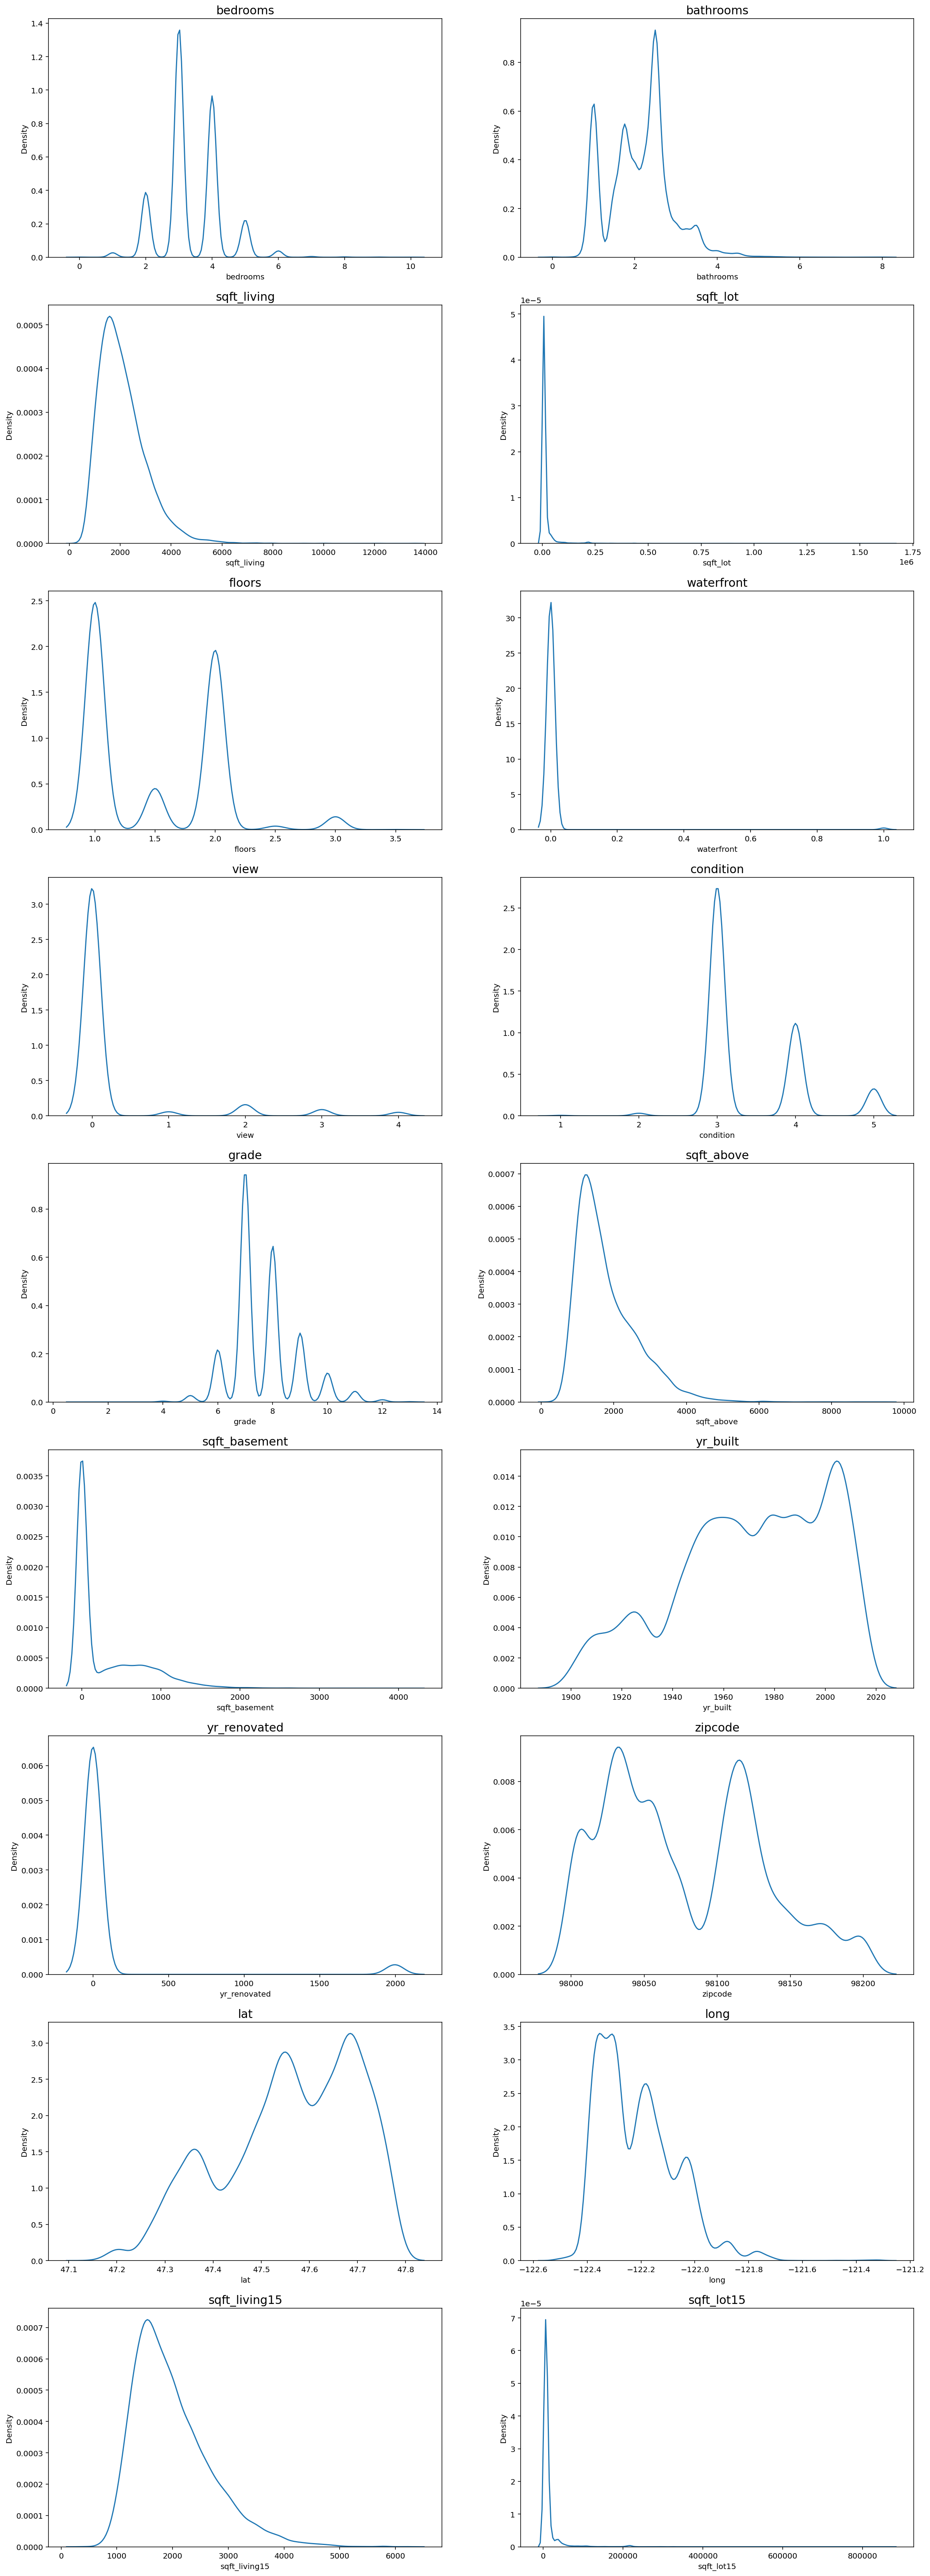

In [80]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [88]:
train_temp = train.copy()
test_temp = test.copy()

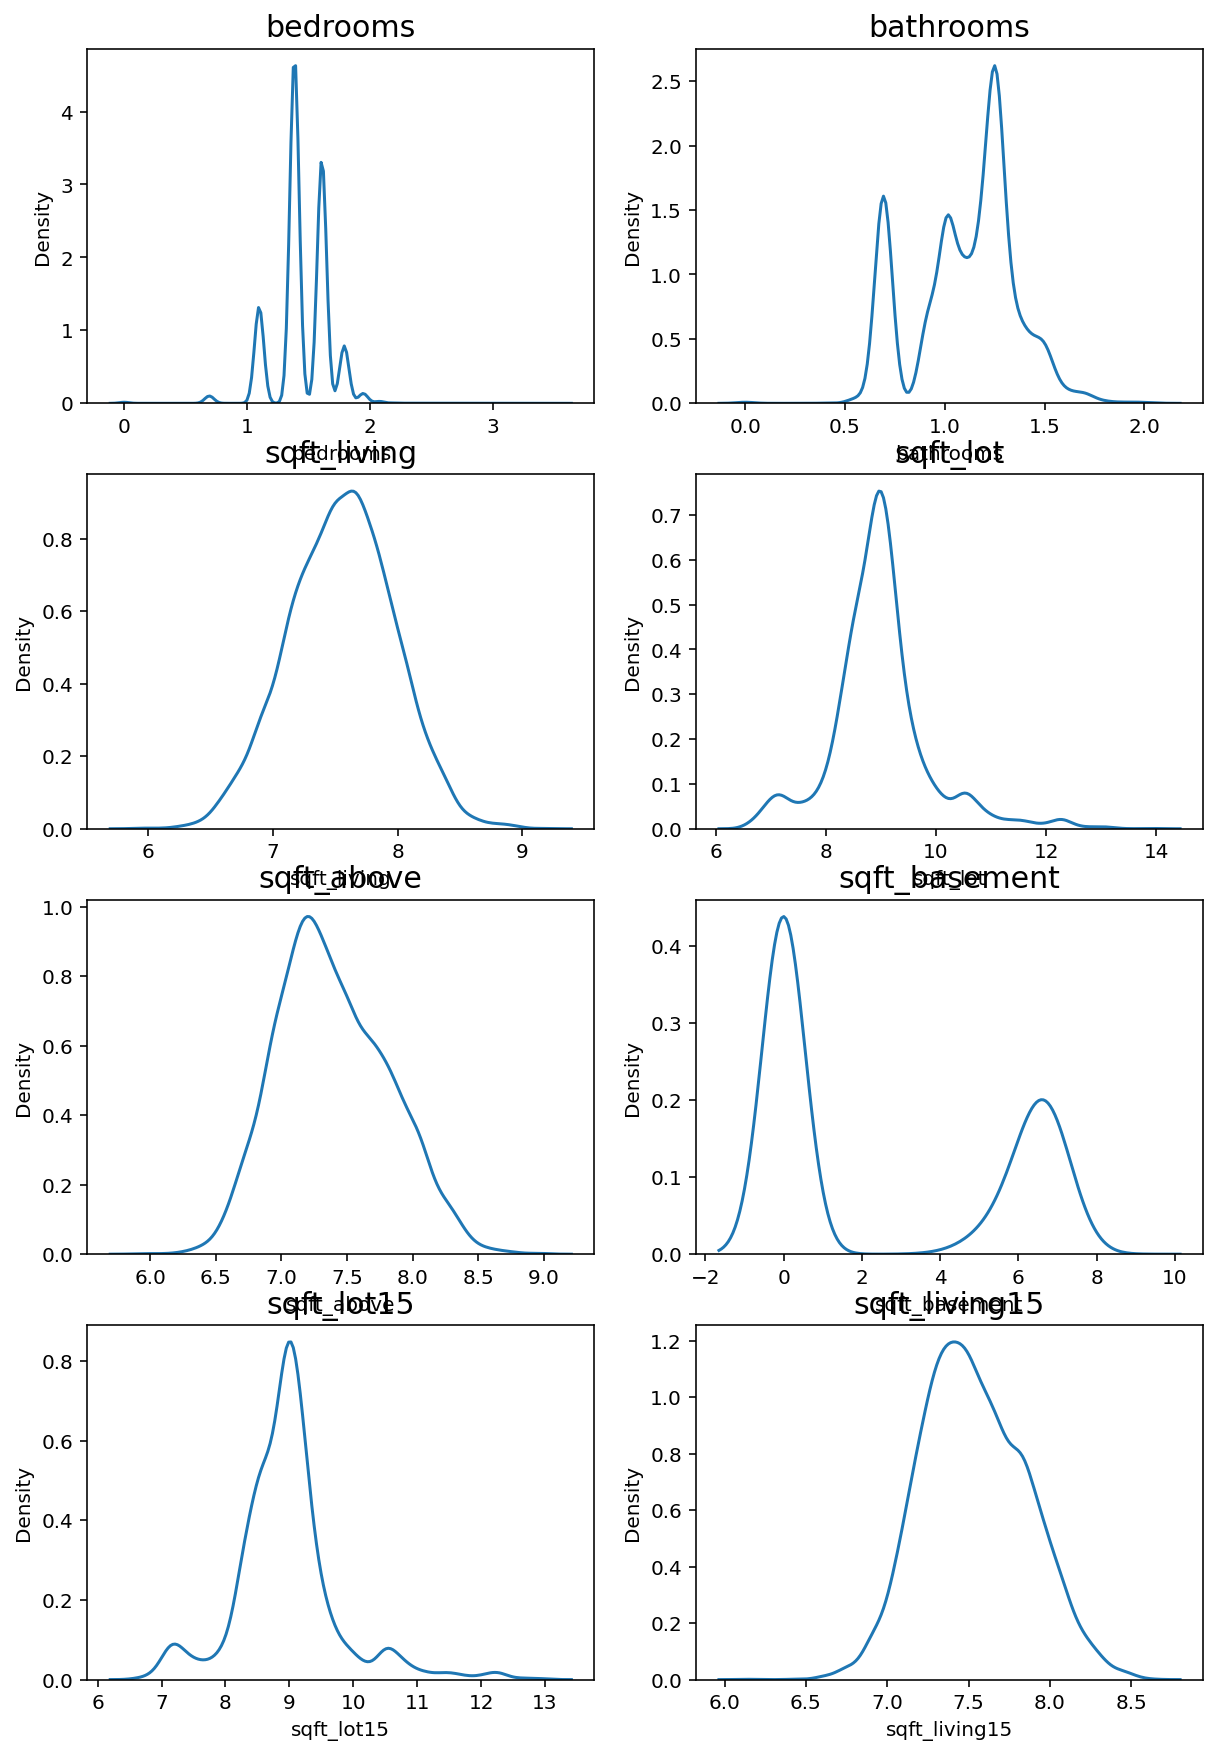

In [89]:
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    test_temp[c] = np.log1p(test_temp[c].values)

fig, ax = plt.subplots(4, 2, figsize=(10, 15))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(test_temp[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

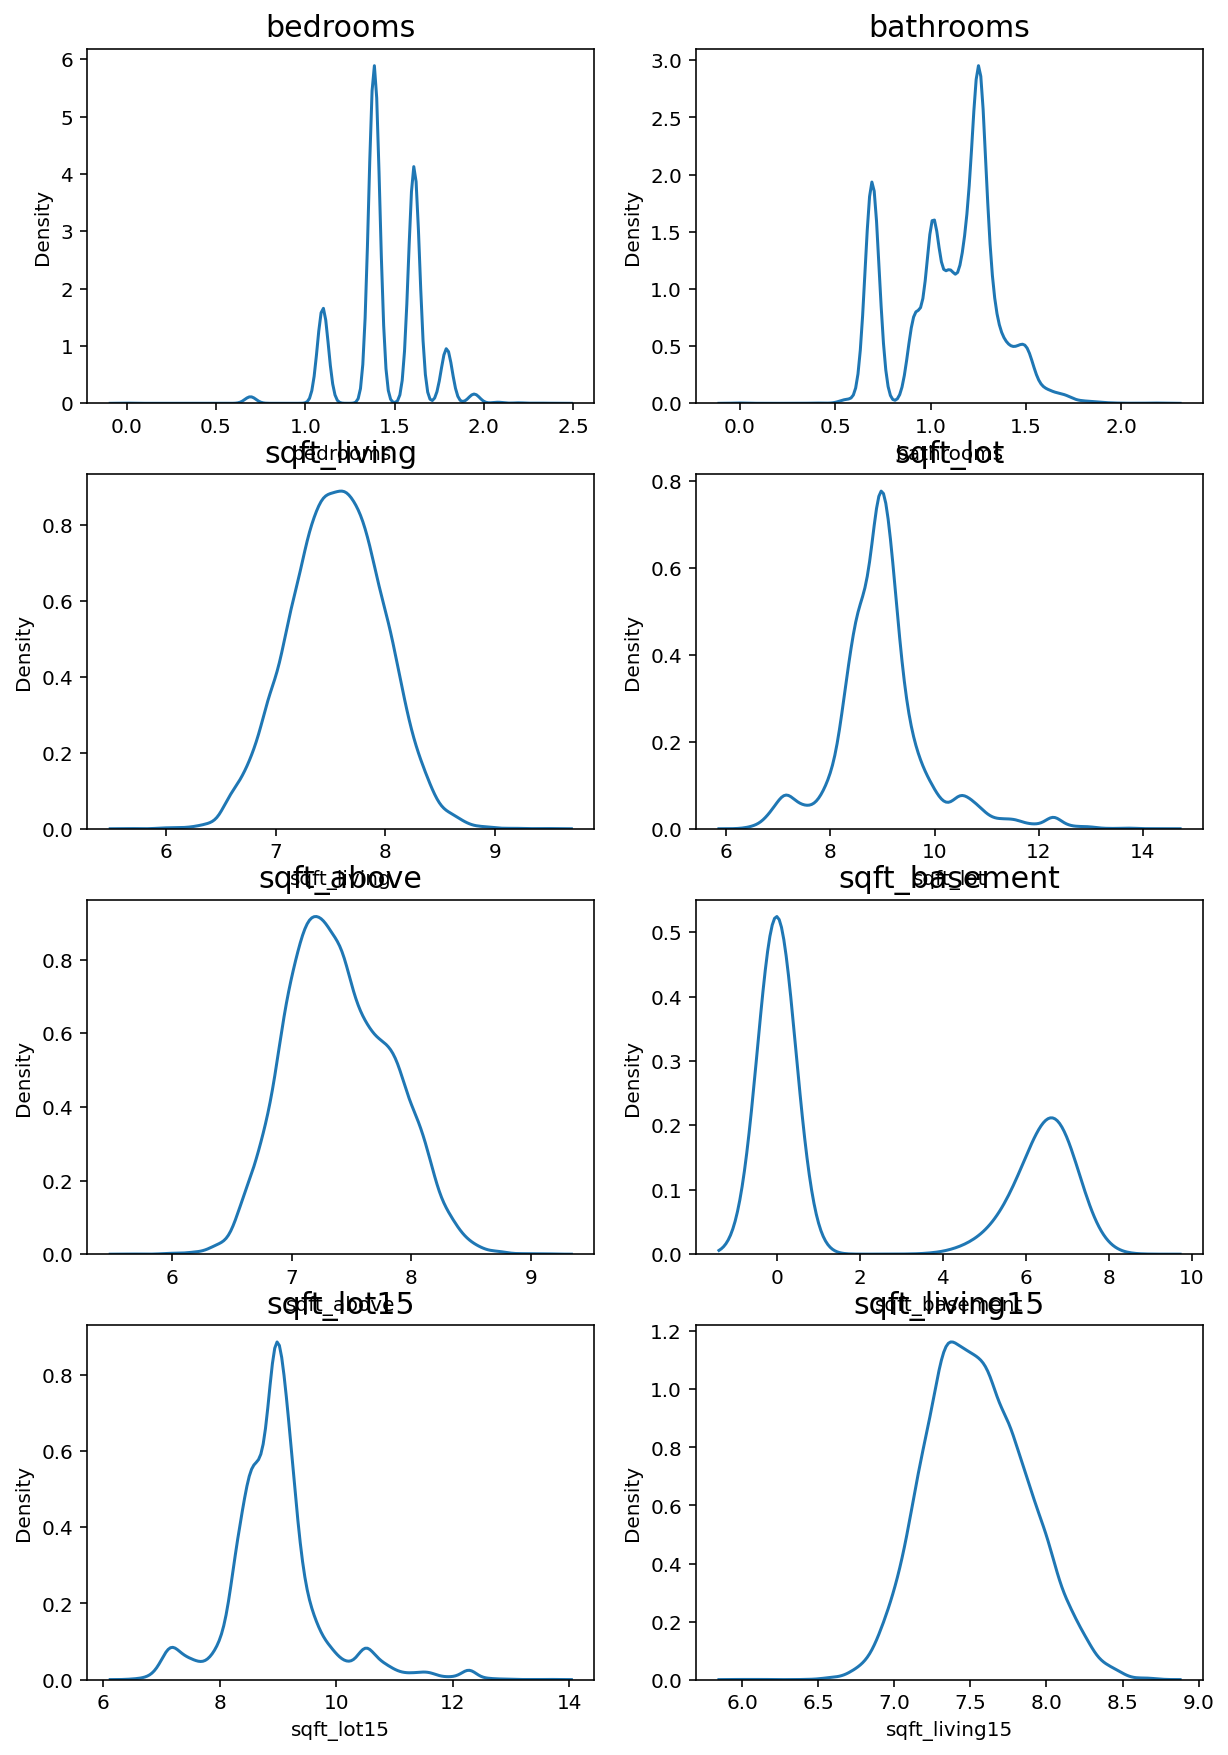

In [90]:
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_temp[c] = np.log1p(train_temp[c].values)

fig, ax = plt.subplots(4, 2, figsize=(10, 15))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(train_temp[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [92]:
get_scores(models, train_temp, y)

,RMSE
GradientBoostingRegressor,127794.131777
RandomForestRegressor,126581.573434
XGBRegressor,111203.466748
LGBMRegressor,109986.995968


In [94]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_temp, y, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_temp, y, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_temp, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_temp, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           100 -0.027024  0.164391
2         10            50 -0.029174  0.170804
1          1           100 -0.055024  0.234571
0          1            50 -0.073398  0.270920
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           100 -0.035224  0.187681
2         10            50 -0.035432  0.188233
1          1           100 -0.179128  0.423235
0          1            50 -0.179746  0.423965
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           100 -0.029444  0.171591
2         10            50 -0.029851  0.172775
1          1           100 -0.055039  0.234604
0          1            50 -0.073256  0.270658
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2       

In [95]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_temp, y, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_temp, y, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_temp, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_temp, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           200 -0.026187  0.161824
2         10            50 -0.029174  0.170804
1          1           200 -0.045198  0.212597
0          1            50 -0.073398  0.270920
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           200 -0.034927  0.186889
2         10            50 -0.035432  0.188233
1          1           200 -0.178639  0.422657
0          1            50 -0.179746  0.423965
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           200 -0.029389  0.171431
2         10            50 -0.029851  0.172775
1          1           200 -0.045150  0.212485
0          1            50 -0.073256  0.270658
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2       

In [96]:
model = LGBMRegressor(max_depth=10, n_estimators=200, random_state=random_state)
model.fit(train_temp, y)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


In [98]:
prediction

array([ 502497.45344159,  471832.63004422, 1359938.40440557, ...,
        465584.37153575,  333259.11662906,  433031.91757954])

# 로그변환 후 값 rmsle값은 살짝 변했으나

# predict값이 변화가 없었다.

In [13]:
train_temp = train.copy()
test_temp = test.copy()

In [14]:
train_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [17]:
train_temp[train_temp['yr_renovated'] != 0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
26,201406,3,2.50,2300,3060,1.5,0,0,3,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
78,201411,3,3.50,4380,6350,2.0,0,0,3,8,2780,1600,1900,1999,98117,47.6981,-122.368,1830,6350
149,201502,5,3.00,3300,33474,1.0,0,3,3,9,1870,1430,1957,1991,98040,47.5673,-122.210,3836,20953
160,201504,2,1.75,1450,15798,2.0,1,4,3,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193
166,201503,4,1.00,1970,4740,1.5,0,0,3,7,1670,300,1904,2005,98122,47.6136,-122.303,1510,4740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13626,201411,3,1.75,1397,18000,1.0,0,0,3,7,1397,0,1965,2014,98092,47.3388,-122.166,1950,31294
13641,201407,2,1.00,900,6000,1.0,0,0,3,7,900,0,1944,2004,98115,47.6855,-122.289,1460,4800
13952,201409,3,2.00,1520,5040,2.0,0,0,3,7,1520,0,1977,2006,98177,47.7770,-122.362,1860,8710
14218,201502,4,2.50,2400,9612,1.0,0,0,3,8,1230,1170,1962,2009,98059,47.4799,-122.127,2430,5539


In [18]:
train_temp[train_temp['waterfront'] != 0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
160,201504,2,1.75,1450,15798,2.0,1,4,3,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193
174,201409,4,2.50,3650,8354,1.0,1,4,3,9,1830,1820,2000,0,98074,47.6338,-122.072,3120,18841
212,201406,4,5.00,4550,18641,1.0,1,4,3,10,2600,1950,2002,0,98074,47.6053,-122.077,4550,19508
332,201411,3,3.00,1970,20978,2.0,1,3,4,9,1770,200,1980,0,98070,47.3844,-122.438,2280,75396
396,201502,3,2.50,5403,24069,2.0,1,4,4,12,5403,0,1976,0,98166,47.4169,-122.348,3980,104374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,201405,2,1.75,2040,28593,1.5,1,3,4,7,2040,0,1919,1990,98070,47.3979,-122.465,2040,35124
13903,201503,3,2.50,2830,4334,3.0,1,4,3,10,2830,0,2006,0,98074,47.6318,-122.071,2830,38211
14139,201408,3,3.50,4410,10756,2.0,1,4,3,11,3430,980,2014,0,98056,47.5283,-122.205,3550,5634
14425,201504,4,4.00,4360,8175,2.5,1,4,3,10,3940,420,2007,0,98008,47.5724,-122.104,2670,8525


In [19]:
train_temp[train_temp['view'] != 0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10,201501,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
16,201408,3,2.75,3050,44867,1.0,0,4,3,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336
39,201408,5,3.25,3250,14342,2.0,0,4,4,8,3250,0,1968,0,98008,47.5880,-122.116,2960,11044
40,201412,3,2.25,2150,21235,1.0,0,3,4,8,1590,560,1959,0,98166,47.4336,-122.339,2570,18900
67,201405,3,2.50,2320,36847,2.0,0,2,3,9,2320,0,1992,0,98045,47.4838,-121.714,2550,35065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14980,201502,3,2.25,1333,1470,3.0,0,3,3,7,1333,0,2009,0,98125,47.7058,-122.302,1360,1680
14981,201501,5,3.50,4410,13000,2.0,0,3,3,10,2920,1490,2014,0,98006,47.5382,-122.111,5790,12969
14993,201408,3,2.50,2198,6222,2.0,0,2,3,8,2198,0,2010,0,98198,47.3906,-122.304,2198,7621
15012,201405,3,3.25,1730,1229,2.0,0,2,3,9,1320,410,2008,0,98119,47.6374,-122.369,1710,1686


In [23]:
train_temp[(train_temp['waterfront'] != 0) & (train_temp['view'] != 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
160,201504,2,1.75,1450,15798,2.0,1,4,3,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193
174,201409,4,2.50,3650,8354,1.0,1,4,3,9,1830,1820,2000,0,98074,47.6338,-122.072,3120,18841
212,201406,4,5.00,4550,18641,1.0,1,4,3,10,2600,1950,2002,0,98074,47.6053,-122.077,4550,19508
332,201411,3,3.00,1970,20978,2.0,1,3,4,9,1770,200,1980,0,98070,47.3844,-122.438,2280,75396
396,201502,3,2.50,5403,24069,2.0,1,4,4,12,5403,0,1976,0,98166,47.4169,-122.348,3980,104374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,201405,2,1.75,2040,28593,1.5,1,3,4,7,2040,0,1919,1990,98070,47.3979,-122.465,2040,35124
13903,201503,3,2.50,2830,4334,3.0,1,4,3,10,2830,0,2006,0,98074,47.6318,-122.071,2830,38211
14139,201408,3,3.50,4410,10756,2.0,1,4,3,11,3430,980,2014,0,98056,47.5283,-122.205,3550,5634
14425,201504,4,4.00,4360,8175,2.5,1,4,3,10,3940,420,2007,0,98008,47.5724,-122.104,2670,8525


In [25]:
waterview = train_temp[(train_temp['waterfront'] != 0) & (train_temp['view'] != 0)].copy()

In [29]:
waterview[waterview['grade'] > 6]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
160,201504,2,1.75,1450,15798,2.0,1,4,3,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193
174,201409,4,2.50,3650,8354,1.0,1,4,3,9,1830,1820,2000,0,98074,47.6338,-122.072,3120,18841
212,201406,4,5.00,4550,18641,1.0,1,4,3,10,2600,1950,2002,0,98074,47.6053,-122.077,4550,19508
332,201411,3,3.00,1970,20978,2.0,1,3,4,9,1770,200,1980,0,98070,47.3844,-122.438,2280,75396
396,201502,3,2.50,5403,24069,2.0,1,4,4,12,5403,0,1976,0,98166,47.4169,-122.348,3980,104374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,201405,2,1.75,2040,28593,1.5,1,3,4,7,2040,0,1919,1990,98070,47.3979,-122.465,2040,35124
13903,201503,3,2.50,2830,4334,3.0,1,4,3,10,2830,0,2006,0,98074,47.6318,-122.071,2830,38211
14139,201408,3,3.50,4410,10756,2.0,1,4,3,11,3430,980,2014,0,98056,47.5283,-122.205,3550,5634
14425,201504,4,4.00,4360,8175,2.5,1,4,3,10,3940,420,2007,0,98008,47.5724,-122.104,2670,8525


In [37]:
(set(waterview['zipcode']))

{98004,
 98006,
 98008,
 98023,
 98027,
 98028,
 98033,
 98034,
 98039,
 98040,
 98052,
 98056,
 98070,
 98074,
 98075,
 98105,
 98118,
 98125,
 98136,
 98144,
 98146,
 98155,
 98166,
 98177,
 98178,
 98198,
 98199}

In [32]:
len(set(train['zipcode']))

70

In [35]:
set(waterview['yr_built'])

{1903,
 1905,
 1908,
 1912,
 1913,
 1915,
 1916,
 1917,
 1918,
 1919,
 1923,
 1925,
 1926,
 1928,
 1930,
 1931,
 1933,
 1935,
 1936,
 1937,
 1939,
 1940,
 1941,
 1942,
 1943,
 1945,
 1947,
 1949,
 1951,
 1952,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1965,
 1968,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1985,
 1989,
 1990,
 1991,
 1992,
 1993,
 1996,
 1998,
 1999,
 2000,
 2001,
 2002,
 2004,
 2005,
 2006,
 2007,
 2014}

In [38]:
train_cut = train_temp[['date', 'bedrooms', 'bathrooms', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15'].copy()]

In [39]:
train_cut

,date,bedrooms,bathrooms,waterfront,view,condition,grade,sqft_basement,zipcode,sqft_living15,sqft_lot15
0,201410,3,1.00,0,0,3,7,0,98178,1340,5650
1,201502,2,1.00,0,0,3,6,0,98028,2720,8062
2,201502,3,2.00,0,0,3,8,0,98074,1800,7503
3,201406,3,2.25,0,0,3,7,0,98003,2238,6819
4,201501,3,1.50,0,0,3,7,0,98198,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,0,0,3,9,0,98056,2520,6023
15031,201503,4,3.50,0,0,3,9,910,98136,2050,6200
15032,201405,3,2.50,0,0,3,8,0,98103,1530,1509
15033,201502,4,2.50,0,0,3,8,0,98146,1830,7200


In [89]:
train_cut2 = train_temp[['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15'].copy()]

In [90]:
train_cut2

,bedrooms,bathrooms,waterfront,view,condition,grade,sqft_basement,zipcode,sqft_living15,sqft_lot15
0,3,1.00,0,0,3,7,0,98178,1340,5650
1,2,1.00,0,0,3,6,0,98028,2720,8062
2,3,2.00,0,0,3,8,0,98074,1800,7503
3,3,2.25,0,0,3,7,0,98003,2238,6819
4,3,1.50,0,0,3,7,0,98198,1650,9711
...,...,...,...,...,...,...,...,...,...,...
15030,4,2.50,0,0,3,9,0,98056,2520,6023
15031,4,3.50,0,0,3,9,910,98136,2050,6200
15032,3,2.50,0,0,3,8,0,98103,1530,1509
15033,4,2.50,0,0,3,8,0,98146,1830,7200


In [92]:
train_cut3 = train_temp[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot' ,'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15'].copy()]

In [94]:
train_cut4 = train_temp[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot' ,'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated' ,'zipcode', 'sqft_living15', 'sqft_lot15'].copy()]

In [96]:
train_cut5 = train_temp[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot' ,'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [98]:
train_cut6 = train_temp[['date','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot' ,'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [105]:
train_cut7 = train_temp[['date','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot' ,'waterfront', 'view', 'condition', 'grade', 'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [104]:
train_cut8 = train_temp[['date','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors' ,'waterfront', 'view', 'condition', 'grade', 'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [107]:
train_cut9 = train_temp[['date','bedrooms', 'bathrooms','floors' ,'waterfront', 'view', 'condition', 'grade', 'sqft_above' ,'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [109]:
train_cut10 = train_temp[['date','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors' ,'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'zipcode', 'lat', 'long' ,'sqft_living15', 'sqft_lot15'].copy()]

In [111]:
train_cut10

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,98146,47.5107,-122.362,1830,7200


In [112]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [91]:
get_scores(models, train_cut2, y)

,RMSE
LinearRegression,215621.081988
GradientBoostingRegressor,165970.913773
RandomForestRegressor,161226.199909
XGBRegressor,137527.528999
LGBMRegressor,135975.233418


In [86]:
get_scores(models, train, y)

,RMSE
LinearRegression,181304.125482
GradientBoostingRegressor,127794.435994
RandomForestRegressor,126787.065455
XGBRegressor,111191.257032
LGBMRegressor,109986.684382


In [85]:
get_scores(models, train_cut, y)

,RMSE
LinearRegression,215479.876653
GradientBoostingRegressor,165834.765534
RandomForestRegressor,162479.811654
XGBRegressor,138248.215276
LGBMRegressor,133480.707842


In [93]:
get_scores(models, train_cut3, y)

,RMSE
LinearRegression,215142.185466
GradientBoostingRegressor,159812.677823
RandomForestRegressor,156397.817014
XGBRegressor,132486.653696
LGBMRegressor,126882.634452


In [95]:
get_scores(models, train_cut4, y)

,RMSE
LinearRegression,202422.105073
RandomForestRegressor,158587.811147
GradientBoostingRegressor,154219.690760
XGBRegressor,131315.906944
LGBMRegressor,126580.016108


In [97]:
get_scores(models, train_cut5, y)

,RMSE
LinearRegression,190375.293589
GradientBoostingRegressor,130067.033914
RandomForestRegressor,126338.222129
LGBMRegressor,117698.725565
XGBRegressor,116354.911116


In [99]:
get_scores(models, train_cut6, y)

,RMSE
LinearRegression,190010.967413
GradientBoostingRegressor,130104.049282
RandomForestRegressor,126959.852964
XGBRegressor,118052.442917
LGBMRegressor,116060.807347


In [101]:
get_scores(models, train_cut7, y)

,RMSE
LinearRegression,190019.861263
GradientBoostingRegressor,130481.110959
RandomForestRegressor,126715.957598
XGBRegressor,119826.944047
LGBMRegressor,117801.006952


In [106]:
get_scores(models, train_cut8, y)

,RMSE
LinearRegression,189962.719102
GradientBoostingRegressor,129997.520420
RandomForestRegressor,127462.871465
LGBMRegressor,116389.367104
XGBRegressor,113023.123504


In [108]:
get_scores(models, train_cut9, y)

,RMSE
LinearRegression,191253.162722
GradientBoostingRegressor,128859.270734
RandomForestRegressor,127725.675897
XGBRegressor,117600.611036
LGBMRegressor,116544.257059


In [110]:
get_scores(models, train_cut10, y)

,RMSE
LinearRegression,189866.361992
GradientBoostingRegressor,130231.910338
RandomForestRegressor,126238.891077
LGBMRegressor,114903.839125
XGBRegressor,112072.256676


In [52]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut, y, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut, y, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut, y, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.038563  0.196375
3         20           200 -0.038886  0.197196
2         20            50 -0.046744  0.216203
0         10            50 -0.047856  0.218759
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         20           200 -0.053221  0.230696
2         20            50 -0.054105  0.232605
1         10           200 -0.069000  0.262678
0         10            50 -0.069489  0.263608
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.046361  0.215317
0         10            50 -0.048634  0.220531
2         20            50 -0.082168  0.286650
3         20           200 -0.08

In [113]:
waterview.min()

date             201405.0000
bedrooms              1.0000
bathrooms             0.7500
sqft_living         720.0000
sqft_lot           1767.0000
floors                1.0000
waterfront            1.0000
view                  1.0000
condition             1.0000
grade                 5.0000
sqft_above          560.0000
sqft_basement         0.0000
yr_built           1903.0000
yr_renovated          0.0000
zipcode           98004.0000
lat                  47.3351
long               -122.5140
sqft_living15       750.0000
sqft_lot15         3230.0000
dtype: float64

In [133]:
waterview[waterview['view'] == 1]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9463,201412,3,1.75,1940,167125,1.0,1,1,4,7,1480,460,1955,0,98070,47.459,-122.504,1910,127195


In [130]:
data[data['waterfront'] == 1].min()

id                           160
date             20140509T000000
price                   285000.0
bedrooms                       1
bathrooms                   0.75
sqft_living                  720
sqft_lot                    1767
floors                       1.0
waterfront                     1
view                           1
condition                      1
grade                          5
sqft_above                   560
sqft_basement                  0
yr_built                    1903
yr_renovated                   0
zipcode                    98004
lat                      47.3351
long                    -122.514
sqft_living15                750
sqft_lot15                  3230
dtype: object

In [138]:
data[(data['grade'] == 5) & (data['waterfront'] == 1)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10729,10729,20150114T000000,658000.0,2,1.0,1010,14244,1.0,1,4,...,5,1010,0,1926,0,98136,47.5476,-122.399,1820,15792
12706,12706,20141117T000000,285000.0,1,1.0,1060,54846,1.0,1,4,...,5,1060,0,1935,0,98070,47.4716,-122.445,2258,31762


In [140]:
data[(data['sqft_living']< 1000) & (data['waterfront'] == 1)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12533,12533,20140627T000000,528000.0,2,0.75,840,40642,1.0,1,4,...,6,840,0,1937,0,98070,47.4040,-122.447,1850,64069
12924,12924,20150422T000000,570000.0,1,1.00,720,7540,1.0,1,4,...,6,720,0,1905,0,98198,47.3509,-122.323,1120,9736
13209,13209,20140616T000000,385000.0,2,1.00,830,26329,1.0,1,3,...,6,830,0,1928,0,98070,47.4012,-122.425,2030,27338


In [141]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [142]:
train_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [143]:
train_temp = train_temp[train_temp['waterfront'] == 0]

In [144]:
train_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [150]:
train_temp = train_temp.drop(['waterfront'],axis=1)

In [151]:
train_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [155]:
y_temp = y.copy()

In [157]:
y_temp = y_temp[train['waterfront'] == 0]

In [158]:
get_scores(models, train_temp, y_temp)

,RMSE
LinearRegression,195550.430041
GradientBoostingRegressor,132060.186808
RandomForestRegressor,122402.740093
LGBMRegressor,117530.447323
XGBRegressor,111811.405659


In [159]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.025644  0.160137
3         20           200 -0.025913  0.160974
2         20            50 -0.028492  0.168796
0         10            50 -0.028603  0.169126
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         20           200 -0.030255  0.173939
2         20            50 -0.030859  0.175667
1         10           200 -0.033418  0.182805
0         10            50 -0.033786  0.183810
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.028784  0.169658
0         10            50 -0.029193  0.170859
2         20            50 -0.049179  0.221764
3         20           200 -0.04

In [176]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.025644  0.160137
3         20           200 -0.025913  0.160974
0         10           100 -0.026517  0.162840
2         20           100 -0.026587  0.163057
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         20           200 -0.030255  0.173939
2         20           100 -0.030492  0.174619
1         10           200 -0.033418  0.182805
0         10           100 -0.033559  0.183191
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.028784  0.169658
0         10           100 -0.028816  0.169752
2         20           100 -0.049255  0.221935
3         20           200 -0.049255  0.221935
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0       

In [175]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_temp, y_temp, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         10           100 -0.026517  0.162840
3         20           100 -0.026587  0.163057
2         20            50 -0.028492  0.168796
0         10            50 -0.028603  0.169126
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         20           100 -0.030492  0.174619
2         20            50 -0.030859  0.175667
1         10           100 -0.033559  0.183191
0         10            50 -0.033786  0.183810
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           100 -0.028816  0.169752
0         10            50 -0.029193  0.170859
2         20            50 -0.049179  0.221764
3         20           100 -0.04

In [165]:
test_temp = test_temp.drop(['waterfront'],axis=1)

In [198]:
train_temp

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [167]:
submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"

In [170]:
model = LGBMRegressor(max_depth=10, n_estimators=200, random_state=random_state)
model.fit(train_temp, y_temp)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
2019-2nd-ml-month-with-kakr/submission.csv


In [204]:
train_temp = train.copy()

In [205]:
test_temp2 = train_temp.copy()

In [206]:
test_temp2 = test_temp2[test_temp2['yr_renovated'] == 0]

In [207]:
test_temp2 = test_temp2.drop(['yr_renovated'], axis=1)

In [208]:
test_temp2

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,98146,47.5107,-122.362,1830,7200


In [181]:
y_temp2 = y.copy()

In [183]:
y_temp2 = y_temp2[data['yr_renovated'] == 0]

In [184]:
y_temp2

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 14404, dtype: float64

In [187]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [209]:
get_scores(models, test_temp2, y_temp2)

,RMSE
LinearRegression,288119.852525
GradientBoostingRegressor,131621.457028
RandomForestRegressor,131604.310255
XGBRegressor,111792.612532
LGBMRegressor,111276.513816


In [210]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.025569  0.159904
3         20           200 -0.025573  0.159916
0         10           100 -0.026233  0.161965
2         20           100 -0.026268  0.162074
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         20           200 -0.030501  0.174644
2         20           100 -0.030601  0.174930
1         10           200 -0.033721  0.183633
0         10           100 -0.033844  0.183967
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         10           200 -0.029155  0.170748
0         10           100 -0.029166  0.170781
2         20           100 -0.048701  0.220683
3         20           200 -0.04

In [211]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, test_temp2, y_temp2, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         20           200 -0.025573  0.159916
3         30           200 -0.025573  0.159916
0         20           100 -0.026268  0.162074
2         30           100 -0.026268  0.162074
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         30           200 -0.030473  0.174564
1         20           200 -0.030501  0.174644
0         20           100 -0.030601  0.174930
2         30           100 -0.030606  0.174945
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           100 -0.048701  0.220683
1         20           200 -0.048701  0.220684
2         30           100 -0.057529  0.239853
3         30           200 -0.057531  0.239855
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0       

In [228]:
model = LGBMRegressor(max_depth=20, n_estimators=200, random_state=random_state)
model.fit(test_temp2, y_temp2)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
2019-2nd-ml-month-with-kakr/submission.csv


In [58]:
test_temp = test.copy()

In [226]:
test_temp = test_temp.drop(['yr_renovated'], axis=1)

In [227]:
test_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,98144,47.5944,-122.299,1020,2007


In [18]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [20]:
test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [21]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [68]:
train_temp3 = train.copy()

In [31]:
train_temp3[train_temp3['yr_renovated'] == 0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [32]:
train_temp3[(train_temp3['yr_renovated'] == 0) & (train_temp3['waterfront'] == 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [33]:
train_temp3[train_temp3['waterfront'] == 0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [69]:
train_temp3[(train_temp3['yr_renovated'] == 0) | (train_temp3['waterfront'] == 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [82]:
train_cut3

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,3,7,1715,0,1995,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,3,7,1060,0,1963,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,3,9,2520,0,2014,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,3,9,2600,910,2009,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,3,8,1530,0,2009,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,3,8,2310,0,2014,98146,47.5107,-122.362,1830,7200


In [70]:
train_cut3 = train_temp3[(train_temp3['yr_renovated'] == 0) | (train_temp3['waterfront'] == 0)].copy()

In [77]:
train_cut3 = train_cut3.drop(['yr_renovated', 'waterfront'], axis = 1)

In [72]:
y_cut3 = y.copy()

In [73]:
y_cut3 = y_cut3[(train_temp3['yr_renovated'] == 0) | (train_temp3['waterfront'] == 0)]

In [80]:
test_temp = test_temp.drop(['yr_renovated', 'waterfront'], axis = 1)

In [83]:
get_scores(models, train_cut3, y_cut3)

,RMSE
LinearRegression,196692.964232
GradientBoostingRegressor,151411.222023
RandomForestRegressor,139592.279481
XGBRegressor,128743.321113
LGBMRegressor,126206.520949


In [78]:
train_cut3

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,3,7,1715,0,1995,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,3,7,1060,0,1963,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,3,9,2520,0,2014,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,3,9,2600,910,2009,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,3,8,1530,0,2009,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,3,8,2310,0,2014,98146,47.5107,-122.362,1830,7200


In [79]:
y_cut3

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15004, dtype: float64

In [81]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut3, y_cut3, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut3, y_cut3, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut3, y_cut3, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut3, y_cut3, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         20           200 -0.027003  0.164327
3         30           200 -0.027011  0.164352
0         20           100 -0.027657  0.166303
2         30           100 -0.027681  0.166376
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         30           200 -0.031550  0.177624
1         20           200 -0.031563  0.177659
2         30           100 -0.031752  0.178190
0         20           100 -0.031759  0.178211
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         20           100 -0.053075  0.230380
1         20           200 -0.053075  0.230381
2         30           100 -0.061172  0.247330
3         30           200 -0.06

In [60]:
submission_path = "2019-2nd-ml-month-with-kakr/sample_submission.csv"

In [67]:
model = XGBRegressor(max_depth=30, n_estimators=200, random_state=random_state)
model.fit(train_cut3, y_cut3)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


In [84]:
train_temp4 = train.copy()

In [85]:
train_temp4 = train_temp4[train_temp4['yr_renovated'] == 0]

In [87]:
train_temp4 = train_temp4.drop(['lat', 'long'], axis = 1)

In [97]:
train_cut4 = train_temp4

In [89]:
y_cut4 = y.copy()

In [90]:
y_cut4 = y_cut4[train['yr_renovated'] == 0]

In [91]:
y_cut4

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 14404, dtype: float64

In [93]:
test4 = test.copy()

In [95]:
test4 = test4.drop(['lat', 'long'], axis = 1)

In [98]:
get_scores(models, train_cut4, y_cut4)

,RMSE
LinearRegression,270809.566945
RandomForestRegressor,173017.250413
GradientBoostingRegressor,164286.701958
XGBRegressor,140920.362573
LGBMRegressor,125935.683079


In [99]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut4, y_cut4, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut4, y_cut4, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut4, y_cut4, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut4, y_cut4, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
3         30           200 -0.031846  0.178453
1         20           200 -0.032080  0.179109
2         30           100 -0.034173  0.184860
0         20           100 -0.034293  0.185182
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         30           200 -0.047794  0.218619
2         30           100 -0.048065  0.219237
1         20           200 -0.048160  0.219454
0         20           100 -0.048472  0.220163
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         20           200 -0.069983  0.264543
0         20           100 -0.069984  0.264545
2         30           100 -0.090620  0.301032
3         30           200 -0.09

In [100]:
model = LGBMRegressor(max_depth=30, n_estimators=200, random_state=random_state)
model.fit(train_cut3, y_cut3)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


In [101]:
train_cut5 = train.copy()

In [102]:
train_cut5

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [103]:
train_cut5 = train_cut5.drop(['lat', 'long'], axis = 1)

In [104]:
test5 = test.copy()

In [105]:
test5 = test.drop(['lat', 'long'], axis = 1)

In [106]:
y_cut5 = y.copy()

In [107]:
get_scores(models, train_cut5, y_cut5)

,RMSE
LinearRegression,200752.056587
RandomForestRegressor,159989.895387
GradientBoostingRegressor,153564.433294
XGBRegressor,127545.622894
LGBMRegressor,125656.898991


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut5, y_cut5, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut5, y_cut5, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut5, y_cut5, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut5, y_cut5, param_grid, verbose=2, n_jobs=5)

In [108]:
train_cut6 = train.copy()

In [112]:
train_cut6[(train_cut6['sqft_living'] > 1000) & (train_cut6['waterfront'] == 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [114]:
train_cut6[(train_cut6['sqft_living'] > 1000) & (train_cut6['waterfront'] == 0) & (train_cut6['yr_renovated'] == 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [113]:
train_cut6[(train_cut6['sqft_living'] > 1000)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [115]:
train_cut6[(train_cut6['sqft_living'] > 1000) & (train_cut6['yr_renovated'] == 0)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [116]:
train_cut7 = train_cut6[(train_cut6['sqft_living'] > 1000) & (train_cut6['waterfront'] == 0) & (train_cut6['yr_renovated'] == 0)]

In [117]:
y_cut7 = y.copy()

In [118]:
y_cut7 = y_cut7[(train['sqft_living'] > 1000) & (train['waterfront'] == 0) & (train['yr_renovated'] == 0)]

In [120]:
train_cut7 = train_cut7.drop(['waterfront', 'yr_renovated'], axis = 1)

In [119]:
test7 = test.copy()

In [121]:
test7 = test.drop(['waterfront', 'yr_renovated'], axis = 1)

In [122]:
get_scores(models, train_cut7, y_cut7)

,RMSE
LinearRegression,185087.256681
GradientBoostingRegressor,155886.362963
RandomForestRegressor,133578.443576
LGBMRegressor,129467.943750
XGBRegressor,127395.256254


In [123]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score    RMSLE
1         20           200 -0.022910  0.15136
3         30           200 -0.022910  0.15136
0         20           100 -0.023418  0.15303
2         30           100 -0.023418  0.15303
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         30           200 -0.026980  0.164257
1         20           200 -0.026985  0.164271
2         30           100 -0.027124  0.164694
0         20           100 -0.027159  0.164800
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [125]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [30, 40],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut7, y_cut7, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score    RMSLE
1         30           200 -0.022910  0.15136
3         40           200 -0.022910  0.15136
0         30           100 -0.023418  0.15303
2         40           100 -0.023418  0.15303
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         40           200 -0.026956  0.164184
1         30           200 -0.026980  0.164257
0         30           100 -0.027124  0.164694
2         40           100 -0.027133  0.164722
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         30           100 -0.052581  0.229307
1         30           200 -0.052583  0.229309
2         40           100 -0.052665  0.229488
3         40           200 -0.052666  0.229491
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
0         30 

In [138]:
train_cut8 = train.copy()

In [139]:
y_cut8 = y.copy()

In [140]:
train_cut8 = train_cut8[(train['yr_renovated'] == 0) & (train['waterfront'] == 0)]

In [141]:
y_cut8 = y_cut8[(train['yr_renovated'] == 0) & (train['waterfront'] == 0)]

In [142]:
get_scores(models, train_cut8, y_cut8)

,RMSE
LinearRegression,272334.269202
GradientBoostingRegressor,126677.414890
RandomForestRegressor,114756.650929
LGBMRegressor,113793.402040
XGBRegressor,108698.739744


In [143]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [30, 40],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_cut8, y_cut8, param_grid, verbose=2, n_jobs=5)
model2 = RandomForestRegressor(random_state=random_state)
my_GridSearch(model2, train_cut8, y_cut8, param_grid, verbose=2, n_jobs=5)
model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train_cut8, y_cut8, param_grid, verbose=2, n_jobs=5)
model4 = XGBRegressor(random_state=random_state)
my_GridSearch(model4, train_cut8, y_cut8, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   max_depth  n_estimators     score     RMSLE
1         30           200 -0.025406  0.159393
3         40           200 -0.025406  0.159393
0         30           100 -0.025874  0.160854
2         40           100 -0.025874  0.160854
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
1         30           200 -0.029380  0.171405
3         40           200 -0.029381  0.171409
2         40           100 -0.029531  0.171847
0         30           100 -0.029536  0.171859
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
2         40           100 -0.057578  0.239954
0         30           100 -0.057579  0.239956
3         40           200 -0.057579  0.239957
1         30           200 -0.05

In [149]:
train_cut8 = train_cut8.drop(['waterfront', 'yr_renovated'], axis = 1)

In [146]:
test_temp

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,3,11,3890,1530,2001,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,3,7,1050,730,1960,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,3,7,1890,0,2003,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,3,6,1500,0,2014,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,3,8,1490,0,2014,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,3,8,1180,130,2008,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,3,7,1020,0,2009,98144,47.5944,-122.299,1020,2007


In [150]:
model = XGBRegressor(max_depth=30, n_estimators=200, random_state=random_state)
model.fit(train_cut8, y_cut8)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


In [151]:
model = LGBMRegressor(max_depth=30, n_estimators=200, random_state=random_state)
model.fit(train_cut8, y_cut8)
prediction = model.predict(test_temp)


prediction = np.expm1(prediction)


submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = "2019-2nd-ml-month-with-kakr/submission.csv"
submission.to_csv(submission_path, index=False)
print(submission_csv_path)

2019-2nd-ml-month-with-kakr/submission.csv


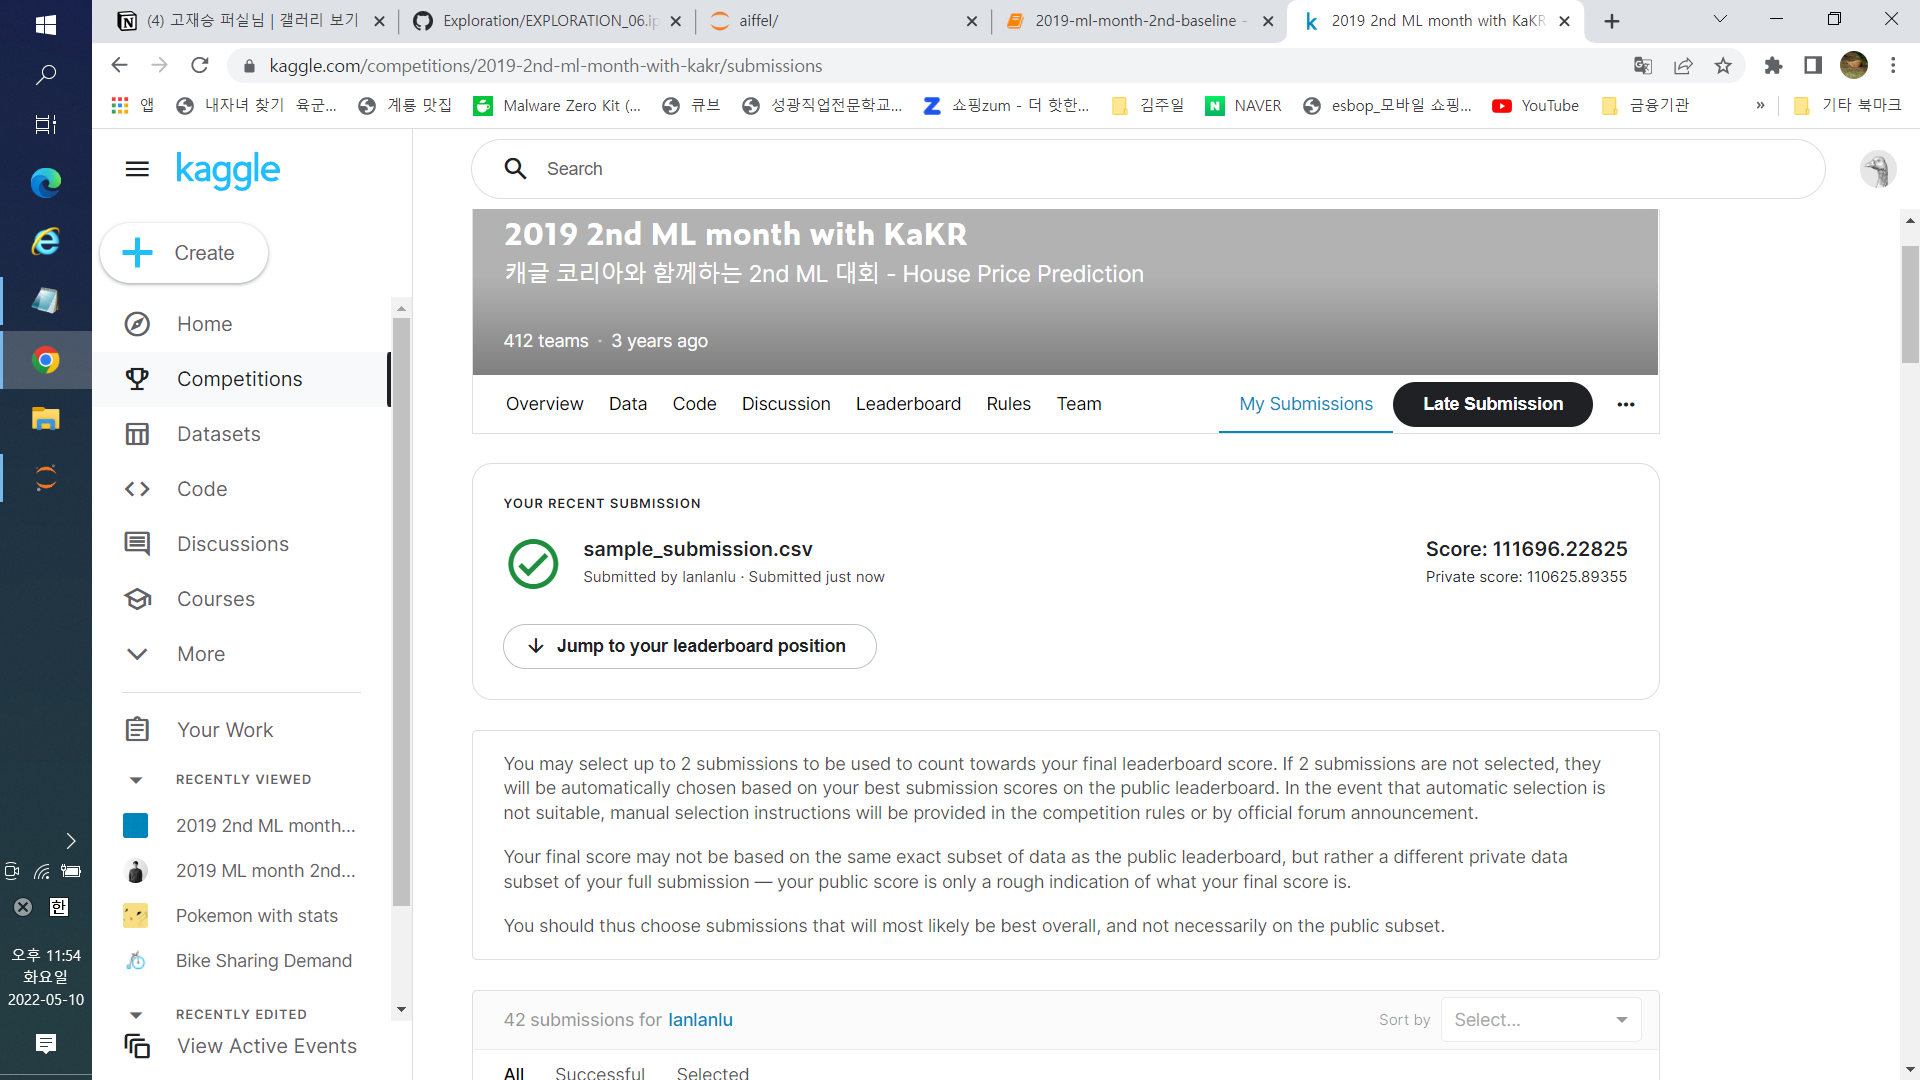

# 결론 : learning_rate를 썻지만 값은 11만625점이 한계였다.....